# Household Power Consumption Prediction with LSTM (regression problem)

### Objective
Conduct an analysis of multivariate time series of electrical power counsumption and use LSTM to predict future average daily consumption of electricity using the past values, develop and compare different approaches to time-series problems.

### Data
The Household Power Consumption dataset is a multivariate time series dataset that describes the electricity consumption for a single household over four years. The data was collected between December 2006 and November 2010 and observations of power consumption within the household were collected every minute. It is a multivariate series comprised of seven variables (besides the date and time); 
they are:
- global active power: The total active power consumed by the household (kilowatts).
- global reactive power: The total reactive power consumed by the household (kilowatts). 
- voltage: Average voltage (volts).
- global intensity: Average current intensity (amps).
- sub metering 1: Active energy for kitchen (watt-hours of active energy).
- sub metering 2: Active energy for laundry (watt-hours of active energy).
- sub metering 3: Active energy for climate control systems (watt-hours of active energy).

source: http://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption

### Role
Worked independently for 3 weeks to extract, clean, analyze, visualize household power consumption data and build LSTM models.

In this project I'll test Vanilla LSTM, Stacked LSTM, Bidirectional LSTM and Hybrid LSTM architectures.

### Models and Tools Used
This project was completed with Python's libraries such as Scikit-learn for data analysis, Matplotlib and Seaborn libraries for visualizations, transformers from Feature-engine library and Tensorflow for building LSTM models.


### Results
Results of this project will be presented in Conclusion Part below.


## Step 0. Import Libraries

In [1]:
# Disable warnings
import warnings
warnings.filterwarnings("ignore")

#For loading dataset & for linear algebra
import numpy as np
import pandas as pd

#Visualization of data & statistical analysis
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from pandas.plotting import autocorrelation_plot

# Feature engineering & preprocessing
from workalendar.europe import France
from feature_engine.imputation import MeanMedianImputer, ArbitraryNumberImputer
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# Pipeline
from sklearn.pipeline import Pipeline

# For building LSTM
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, TimeDistributed, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers.convolutional import Conv1D, MaxPooling1D

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Display text
from sklearn import set_config
set_config(display="text")

### Functions

In [2]:
# Visualizing histogram, probability plot and box-plot

def diagnostic_plots(df, variable):
    fig = plt.figure(figsize = (18, 5))
    
    # Histogram
    plt.subplot(1, 3, 1)
    fig = df[variable].hist(bins = 30)
    fig.set_ylabel ('Count')
    fig.set_xlabel(variable)
    
    # Probability plot
    plt.subplot(1, 3, 2)
    stats.probplot(x = df[variable], dist = 'norm', plot = plt)
    
    # Box-plot
    plt.subplot(1, 3, 3)
    sns.boxplot(y = df[variable])
    plt.title('Boxplot')

    plt.show()

In [3]:
# Visualizing distribution of numerical variable after imputation or after dropping NaN values

def visualizing_distribution_after_imputation(var):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    df_daily[var].plot(kind = 'kde', ax = ax, color = 'black', marker = '1')
    df_daily[var + '_median'].plot(kind = 'kde', ax = ax)
    df_daily[var + '_mean'].plot(kind = 'kde', ax = ax, color = 'y')
    df_daily[var + '_arb'].plot(kind = 'kde', ax = ax)
    lines, labels = ax.get_legend_handles_labels()
    ax.legend(lines, labels, loc = 'best')
    plt.tight_layout()
    plt.show()

In [4]:
# Check rolling statistics

def rolling_statistics(df, variable, window):
    
    #Determine rolling statistics
    plt.figure(figsize = (15, 5))
    rolmean = pd.Series(df[variable]).rolling(window = window).mean()
    rolstd = pd.Series(df[variable]).rolling(window = window).std()

    #Plot rolling statistics:
    orig = plt.plot(df[variable], color = 'olivedrab',label = 'Original')
    mean = plt.plot(rolmean, color = 'salmon', label = 'Rolling Mean')
    std = plt.plot(rolstd, color = 'royalblue', label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation of {}'.format(variable))
    plt.show()

In [5]:
# Check stationarity thhrough Dickey-Fuller Test

def stationary_or_non_stationary(df, variable):

    print ('Results of Dickey-Fuller Test:', variable)
    dftest = adfuller(df[variable], autolag = 'AIC', regression = 'n')
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic',
                                               'p-value',
                                               '#Lags Used',
                                               'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    print(' ')
    print('*********************************************************')
    print(' ')

In [49]:
# Visualize model losses during training LSTM

def plot_model_losses(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])

    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'valid'], loc = 'upper right')
    plt.show()

In [131]:
# Make predictions on train and test sets, compare metrics 
# and visualize predictions & actual values on plot

def model_predict_show_scores_and_plot(model, train_X, test_X, train_y, test_y):

    # make a prediction on train set    
    # for training CNN-LSTM we need 4D shape, so train_X dimension for CNN-LSTM is differed
    
    if model == cnn_lstm:  
        yhat_train = model.predict(train_X_sub)
        train_X = train_X_sub.reshape((train_X_sub.shape[0], subsequences * train_X_sub.shape[2]))
    else:
        yhat_train = model.predict(train_X)
        train_X = train_X.reshape((train_X.shape[0], train_X.shape[2]))

    #  invert scaling for forecast
    inv_yhat_train = np.concatenate((yhat_train, train_X[:, 1:]), axis = 1)
    inv_yhat_train = scaler_y.inverse_transform(inv_yhat_train)
    inv_yhat_train = inv_yhat_train[:, 0]

    ## invert scaling for actual
    train_y = train_y.reshape((len(train_y), 1))
    inv_y_train = np.concatenate((train_y, train_X[:, 1:]), axis = 1)
    inv_y_train = scaler_y.inverse_transform(inv_y_train)
    inv_y_train = inv_y_train[:, 0]
    
    # make a prediction on test set
    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

    # invert scaling for forecast
    inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis = 1)
    inv_yhat = scaler_y.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:, 0]

    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = np.concatenate((test_y, test_X[:, 1:]), axis = 1)
    inv_y = scaler_y.inverse_transform(inv_y)
    inv_y = inv_y[:, 0]
    
    # metrics on train set
    rmse_train = np.sqrt(mean_squared_error(inv_y_train, inv_yhat_train))
    mae_train = mean_absolute_error(inv_y_train, inv_yhat_train)
    mse_train = mean_squared_error(inv_y_train, inv_yhat_train)
    
    rmse_test = np.sqrt(mean_squared_error(inv_y, inv_yhat))
    mae_test = mean_absolute_error(inv_y, inv_yhat)
    mse_test = mean_squared_error(inv_y, inv_yhat)
    
    # metrics on test set
    rmse_train_scores.append(round(rmse_train, 3))
    mae_train_scores.append(round(mae_train, 3))
    mse_train_scores.append(round(mse_train, 3))

    rmse_test_scores.append(round(rmse_test, 3))
    mae_test_scores.append(round(mae_test, 3))
    mse_test_scores.append(round(mse_test, 3))

    print(' ')
    print('Train Mean Absolute Error: %.3f' % mae_train)
    print('Train Mean Squared Error: %.3f' % mse_train)
    print('Train RMSE: %.3f' % rmse_train)

    print(' ')
    print('Test Mean Absolute Error: %.3f' % mae_test)
    print('Test Mean Squared Error: %.3f' % mse_test)
    print('Test RMSE: %.3f' % rmse_test)
    
    
    # plot actual and predicted values with comparing first 100 steps
    
    aa = [x for x in range(100)]

    plt.figure(figsize = (15, 5))
    plt.plot(aa, inv_y[:100], marker = '.', label = 'actual')
    plt.plot(aa, inv_yhat[:100], 'r', marker = 'x', label = 'prediction', linestyle = 'dotted')
    plt.ylabel('Global active power', size = 15)
    plt.xlabel('Time step', size = 15)
    plt.legend()
    plt.show()

## Step 1. Load Dataset

In [6]:
# Load dataset from directory

df = pd.read_csv('../household_power_consumption.txt',
                 sep = ';', 
                 parse_dates = {'dt': ['Date', 'Time']}, 
                 infer_datetime_format = True, 
                 low_memory = False, 
                 na_values = ['nan', '?'], 
                 index_col = 'dt')

In [7]:
# See first 10 rows of dataset
df.head(10)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0
2006-12-16 17:29:00,3.520,0.522,235.02,15.0,0.0,2.0,17.0
2006-12-16 17:30:00,3.702,0.520,235.09,15.8,0.0,1.0,17.0
2006-12-16 17:31:00,3.700,0.520,235.22,15.8,0.0,1.0,17.0
2006-12-16 17:32:00,3.668,0.510,233.99,15.8,0.0,1.0,17.0


In [8]:
# Check information about dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


All features are numerical.

In [9]:
# Check shape of dataset
df.shape

(2075259, 7)

In [10]:
# Check statistical information
df.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


We need to normalize the values before training.

In [11]:
# Check presence of NaN values in datasest
df.isnull().mean()

Global_active_power      0.012518
Global_reactive_power    0.012518
Voltage                  0.012518
Global_intensity         0.012518
Sub_metering_1           0.012518
Sub_metering_2           0.012518
Sub_metering_3           0.012518
dtype: float64

In [12]:
# Check amount on NaN values in dataset
df.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

All 7 variables have the same percentage of NaN values which is about 1.3% or 25.979 observations of whole dataset.

In [13]:
# See the first 20 rows with NaN values
df[df['Global_active_power'].isnull()].head(5)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-21 11:23:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-12-21 11:24:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-12-30 10:08:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-12-30 10:09:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-01-14 18:36:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# See the last 20 rows with NaN values
df[df['Global_active_power'].isnull()].tail(5)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2010-09-28 19:09:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09-28 19:10:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09-28 19:11:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09-28 19:12:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-10-24 15:35:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We may suspect a direct dependence of the lack of data in variables. Perhaps, since the dataset is related to electricity consumption, there were once planned or unscheduled power outages, and therefore, the sensors could not record the consumption of electricity.

I want to predict electricity consumption per day, so i will resample the dataset based on the average consumption per day.

In [15]:
# Resample data by average daily consumption

df_daily = df.resample('D').mean()
df_daily.describe().T

,count,mean,std,min,25%,50%,75%,max
Global_active_power,1433.0,1.092048,0.420415,0.173818,0.816776,1.080732,1.323926,3.314851
Global_reactive_power,1433.0,0.123816,0.034131,0.057811,0.099188,0.119092,0.141454,0.290162
Voltage,1433.0,240.836421,2.045493,231.088229,240.094778,240.965688,241.878583,247.435007
Global_intensity,1433.0,4.629728,1.741352,0.808333,3.503333,4.556111,5.540556,14.028056
Sub_metering_1,1433.0,1.123143,1.113913,0.000000,0.440972,0.775694,1.545139,7.767894
Sub_metering_2,1433.0,1.298620,1.461039,0.000000,0.299306,0.479167,1.897222,8.409028
Sub_metering_3,1433.0,6.444100,2.568978,0.000000,4.638889,6.447222,8.155556,16.488194


After daily resampling we received 1433 observations.

## Step 2. Data preprocessing

### 1. Feature engineering with dates

In [16]:
# Create features of quarter, month, day_of_week, weekofyear and date
df_daily['quarter'] = pd.DatetimeIndex(df_daily.index).quarter
df_daily['month'] = pd.DatetimeIndex(df_daily.index).month
df_daily['day_of_week'] = pd.DatetimeIndex(df_daily.index).day_of_week
df_daily['weekofyear'] = pd.DatetimeIndex(df_daily.index).weekofyear
df_daily['date'] = pd.DatetimeIndex(df_daily.index).date

In [17]:
# Additionally create a feature that describe whether it was working day or holiday

# Load information about holidays(weekends) in France
cal = France()

# Add information about holidays in df
df_daily['working_day'] = df_daily.date.apply(lambda x: cal.is_working_day(pd.to_datetime(x)))

# Encode 'working_day' variable with 0: weekend or holiday and 1: is weekday
label_encoder = LabelEncoder()

# Transform 'working_day' column
df_daily['working_day'] = label_encoder.fit_transform(df_daily['working_day'])

# Check df after transformation
df_daily.head(10)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,quarter,month,day_of_week,weekofyear,date,working_day
dt,,,,,,,,,,,,,
2006-12-16,3.053475,0.088187,236.243763,13.082828,0.000000,1.378788,12.439394,4,12,5,50,2006-12-16,0
2006-12-17,2.354486,0.156949,240.087028,9.999028,1.411806,2.907639,9.264583,4,12,6,50,2006-12-17,0
2006-12-18,1.530435,0.112356,241.231694,6.421667,0.738194,1.820139,9.734722,4,12,0,51,2006-12-18,1
2006-12-19,1.157079,0.104821,241.999313,4.926389,0.582639,5.279167,4.303472,4,12,1,51,2006-12-19,1
2006-12-20,1.545658,0.111804,242.308062,6.467361,0.000000,1.838889,9.765972,4,12,2,51,2006-12-20,1
2006-12-21,1.193758,0.100255,241.040549,5.033797,1.227399,1.824061,7.246871,4,12,3,51,2006-12-21,1
2006-12-22,1.625929,0.129796,241.184549,6.872917,2.188194,0.243056,7.729861,4,12,4,51,2006-12-22,1
2006-12-23,3.314851,0.153799,240.136076,14.028056,1.853472,0.295139,10.226389,4,12,5,51,2006-12-23,0
2006-12-24,1.770842,0.104097,241.687437,7.640417,1.182639,3.529167,4.785417,4,12,6,51,2006-12-24,0


I checked whether the information is reliable and compared with the source: https://www.timeanddate.com/calendar/?year=2010&country=5

In [18]:
# Drop 'date' column. I was needed it to create 'working_day' variable

df_daily = df_daily.drop(labels = ['date'], axis = 1)

In [19]:
# Make a copy of dataset

df_daily_dates = df_daily.copy()

### 2. Feature engineering: imputation methods of missing values

In [20]:
# Let's have a look at df
df_daily.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,quarter,month,day_of_week,weekofyear,working_day
dt,,,,,,,,,,,,
2006-12-16,3.053475,0.088187,236.243763,13.082828,0.000000,1.378788,12.439394,4,12,5,50,0
2006-12-17,2.354486,0.156949,240.087028,9.999028,1.411806,2.907639,9.264583,4,12,6,50,0
2006-12-18,1.530435,0.112356,241.231694,6.421667,0.738194,1.820139,9.734722,4,12,0,51,1
2006-12-19,1.157079,0.104821,241.999313,4.926389,0.582639,5.279167,4.303472,4,12,1,51,1
2006-12-20,1.545658,0.111804,242.308062,6.467361,0.000000,1.838889,9.765972,4,12,2,51,1


In [21]:
# Define list of variables that have missing values

feature_list = df_daily.columns[:-5]
feature_list

Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')

In [16]:
# Create copies of variables for different methods of imputation
for col in feature_list:
    df_daily[col + '_median'] = df_daily[col].copy()
    
    df_daily[col + '_mean'] = df_daily[col].copy()
    
    df_daily[col + '_arb'] = df_daily[col].copy()

In [17]:
# Define df with features that have missing values
var_list = df_daily[feature_list]
var_list

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16,3.053475,0.088187,236.243763,13.082828,0.000000,1.378788,12.439394
2006-12-17,2.354486,0.156949,240.087028,9.999028,1.411806,2.907639,9.264583
2006-12-18,1.530435,0.112356,241.231694,6.421667,0.738194,1.820139,9.734722
2006-12-19,1.157079,0.104821,241.999313,4.926389,0.582639,5.279167,4.303472
2006-12-20,1.545658,0.111804,242.308062,6.467361,0.000000,1.838889,9.765972
...,...,...,...,...,...,...,...
2010-11-22,1.417733,0.098857,240.197118,6.014167,3.371528,1.465278,7.038889
2010-11-23,1.095511,0.095451,240.575528,4.674444,1.299306,0.318056,5.285417
2010-11-24,1.247394,0.091986,240.030965,5.249583,0.761111,1.977778,8.488889


In [18]:
# Create list of variables that will be imputed with median value
median_impute_list = []

for var in var_list:
    median_impute_list.append(var + '_median')
    
median_impute_list    

['Global_active_power_median',
 'Global_reactive_power_median',
 'Voltage_median',
 'Global_intensity_median',
 'Sub_metering_1_median',
 'Sub_metering_2_median',
 'Sub_metering_3_median']

In [19]:
# Create list of variables that will be imputed with mean value
mean_impute_list = []

for var in var_list:
    mean_impute_list.append(var + '_mean')
    
mean_impute_list    

['Global_active_power_mean',
 'Global_reactive_power_mean',
 'Voltage_mean',
 'Global_intensity_mean',
 'Sub_metering_1_mean',
 'Sub_metering_2_mean',
 'Sub_metering_3_mean']

In [20]:
# Create list of variables that will be imputed with arbitrary value
arb_num_impute_list = []

for var in var_list:
    arb_num_impute_list.append(var + '_arb')
    
arb_num_impute_list   

['Global_active_power_arb',
 'Global_reactive_power_arb',
 'Voltage_arb',
 'Global_intensity_arb',
 'Sub_metering_1_arb',
 'Sub_metering_2_arb',
 'Sub_metering_3_arb']

In [21]:
# Impute missing values with mean value
imputer_mean = MeanMedianImputer(imputation_method = 'mean', variables = mean_impute_list)
imputer_mean.fit(df_daily)

# Transform
df_daily = imputer_mean.transform(df_daily)

In [22]:
# Impute missing values with median value
imputer_median = MeanMedianImputer(imputation_method = 'median', variables = median_impute_list)
imputer_median.fit(df_daily)
# Transform
df_daily = imputer_median.transform(df_daily)

In [23]:
# Impute missing values with arbitrary value
imputer_arb = ArbitraryNumberImputer(variables = arb_num_impute_list, arbitrary_number = -1)
imputer_arb.fit(df_daily)

# Transform
df_daily = imputer_arb.transform(df_daily)

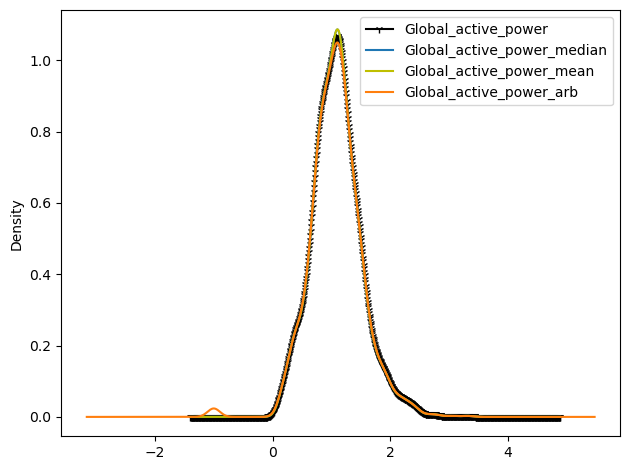

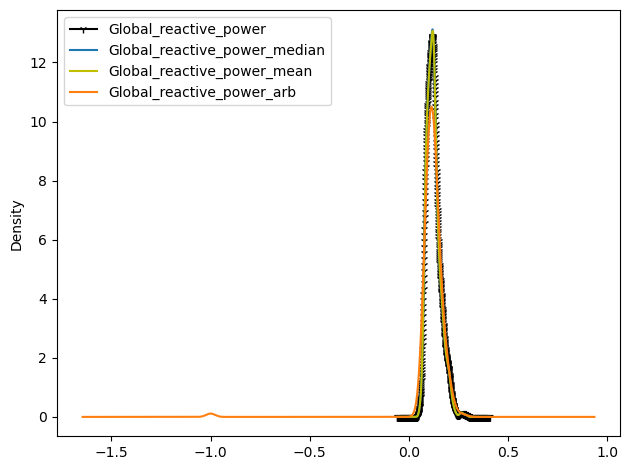

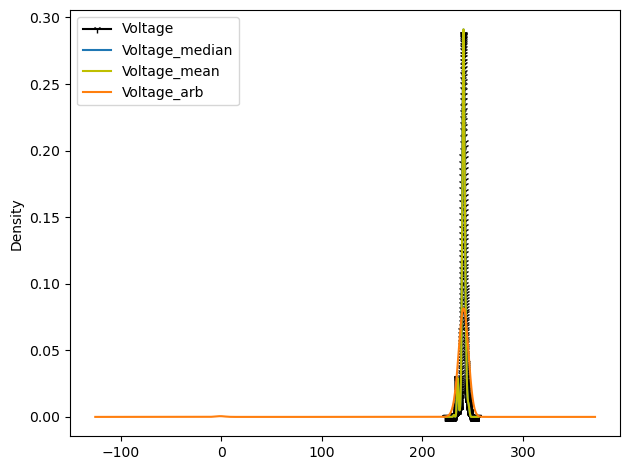

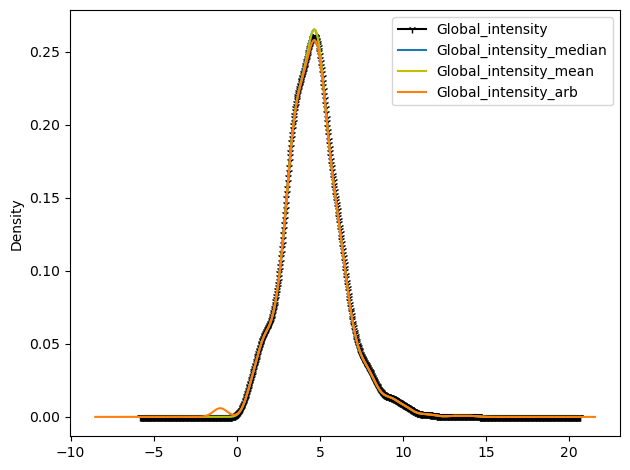

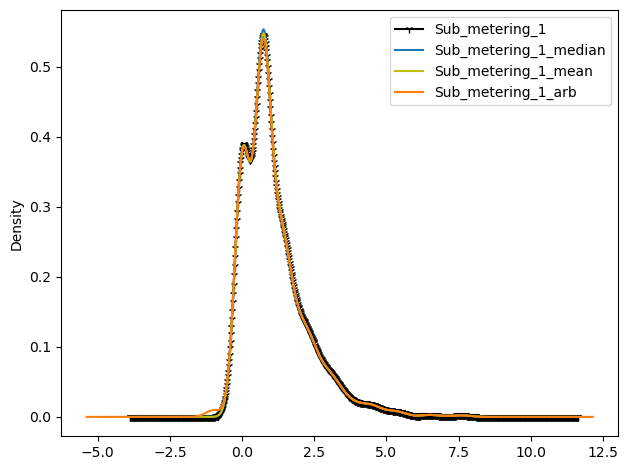

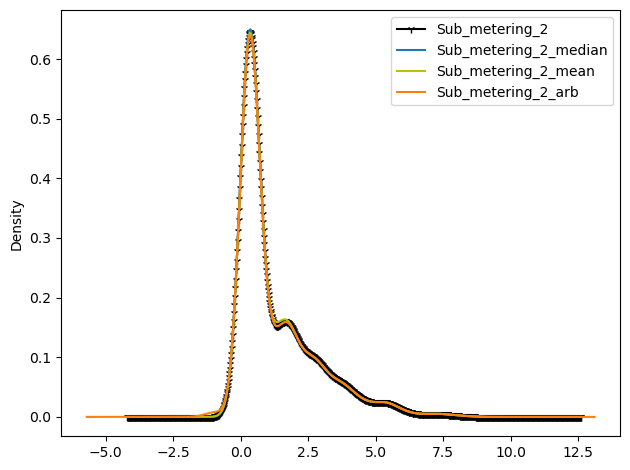

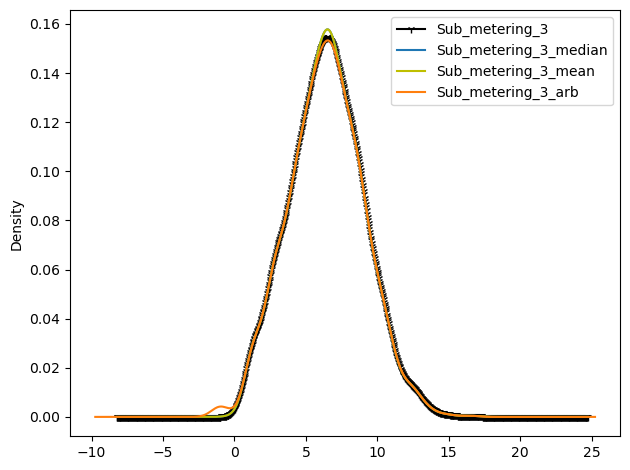

In [24]:
#Compare kde plot with original, imputed variables and after dropping NaN values
for var in var_list:
    visualizing_distribution_after_imputation(var)

We can see that after replacing the missing values with the mean, median, and arbitral values 
the distribution of the data in the variables is almost the same with original distribution as we had about 1% of missing values.

Therefore, we can apply any of the tested missing values imputation methods. But since it is important for me to keep the order in the time series, I will use the imputation method with median value as distribution in variables is skewed.

In [22]:
# For further analysis I'll impute missing values with median value

# Make a copy of df
df_daily_median = df_daily_dates.copy()

In [23]:
# Impute missing values with median value
imputer_median = MeanMedianImputer()
imputer_median.fit(df_daily_median)

# Transform
df_daily_median = imputer_median.transform(df_daily_median)

In [24]:
# Dataset with median value imputation
df_daily_median.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,quarter,month,day_of_week,weekofyear,working_day
dt,,,,,,,,,,,,
2006-12-16,3.053475,0.088187,236.243763,13.082828,0.000000,1.378788,12.439394,4,12,5,50,0
2006-12-17,2.354486,0.156949,240.087028,9.999028,1.411806,2.907639,9.264583,4,12,6,50,0
2006-12-18,1.530435,0.112356,241.231694,6.421667,0.738194,1.820139,9.734722,4,12,0,51,1
2006-12-19,1.157079,0.104821,241.999313,4.926389,0.582639,5.279167,4.303472,4,12,1,51,1
2006-12-20,1.545658,0.111804,242.308062,6.467361,0.000000,1.838889,9.765972,4,12,2,51,1


In [25]:
# Check again the presence of missing values
df_daily_median.isnull().mean()

Global_active_power      0.0
Global_reactive_power    0.0
Voltage                  0.0
Global_intensity         0.0
Sub_metering_1           0.0
Sub_metering_2           0.0
Sub_metering_3           0.0
quarter                  0.0
month                    0.0
day_of_week              0.0
weekofyear               0.0
working_day              0.0
dtype: float64

## Step 3. Patterns in observation over time

## Time Series Data Analysis

1. Series Distribution Check : Time-Series should follow a Gaussian (Normal) Distribution. If the distribution is not normal or skewed then transformations might be useful before modelling.
2. Stationarity Check : A Time Series is said to be stationary if its statistical properties such as mean, variance remain constant over time. Most of the Time Series models work on the assumption that the TS is stationary. Major reason for this is that there are many ways in which a series can be non-stationary, but only one way for stationarity. Intuitively, we can say that if a Time Series has a particular behaviour over time, there is a very high probability that it will follow the same in the future. Also, the theories related to stationary series are more mature and easier to implement as compared to non-stationary series. We can check the stationarity of the series by using various techniques as:
- ACF and PACF plots : If the time series is stationary, the ACF/PACF plots will show a quick drop-off in correlation after a small amount of lag between points.
- Plotting Rolling Statistics : We can plot the moving average or moving variance and see if it varies with time. Moving average/variance is for any instant ‘t’, the average/variance of the last year, i.e. last 12 months.
- Augmented Dickey-Fuller Test: This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary.

source: https://medium.com/analytics-vidhya/time-series-forecasting-in-python-part-1-data-processing-feature-engineering-c347cb3d5e9d

In [26]:
# Check variables in list
feature_list

Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')

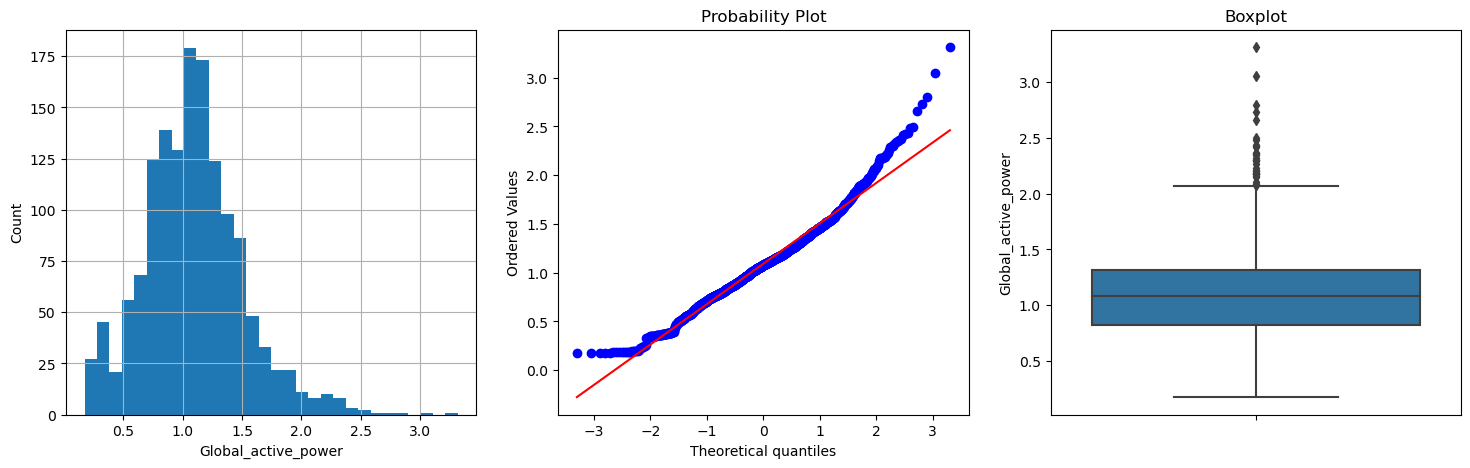

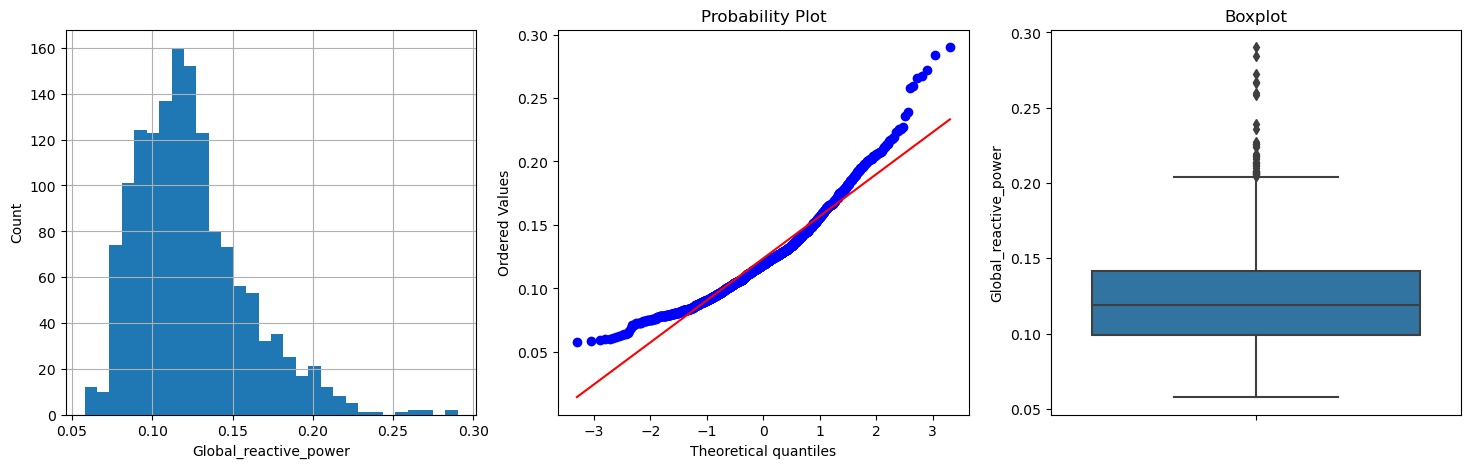

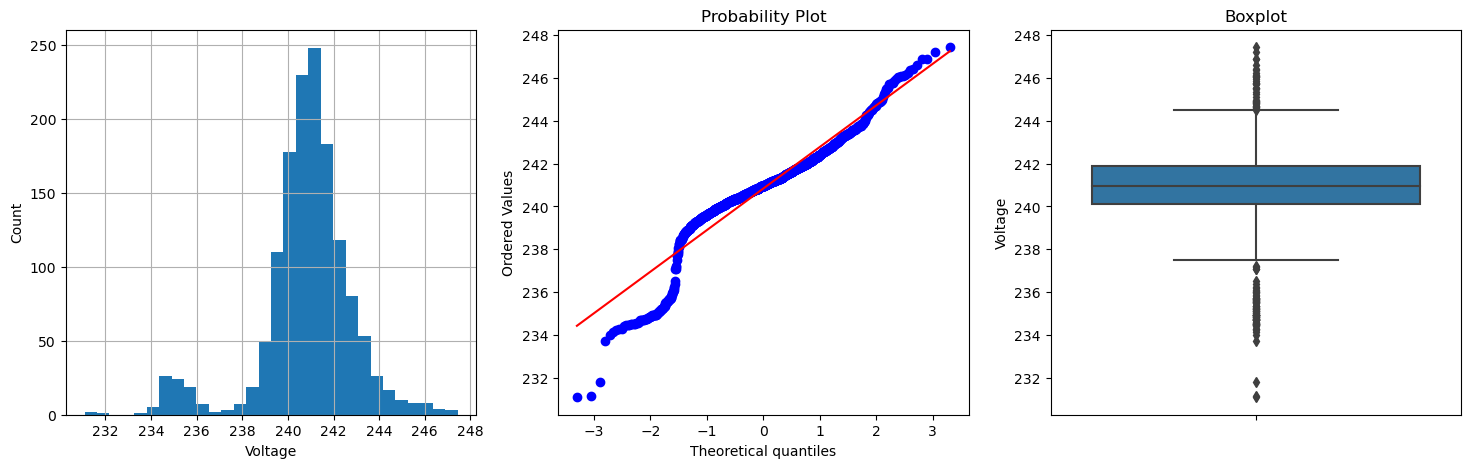

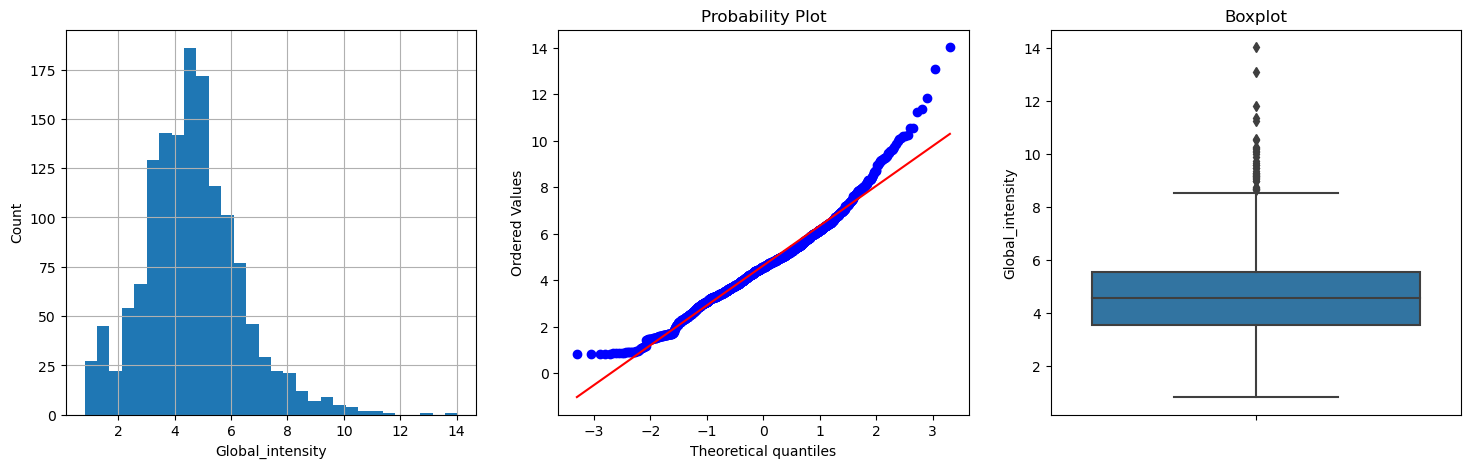

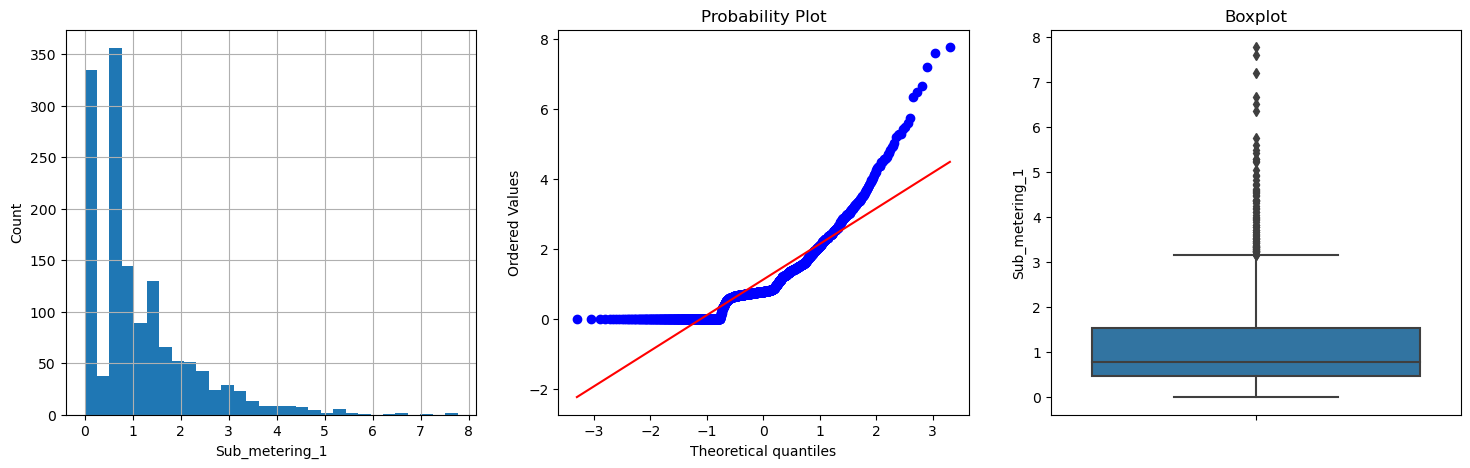

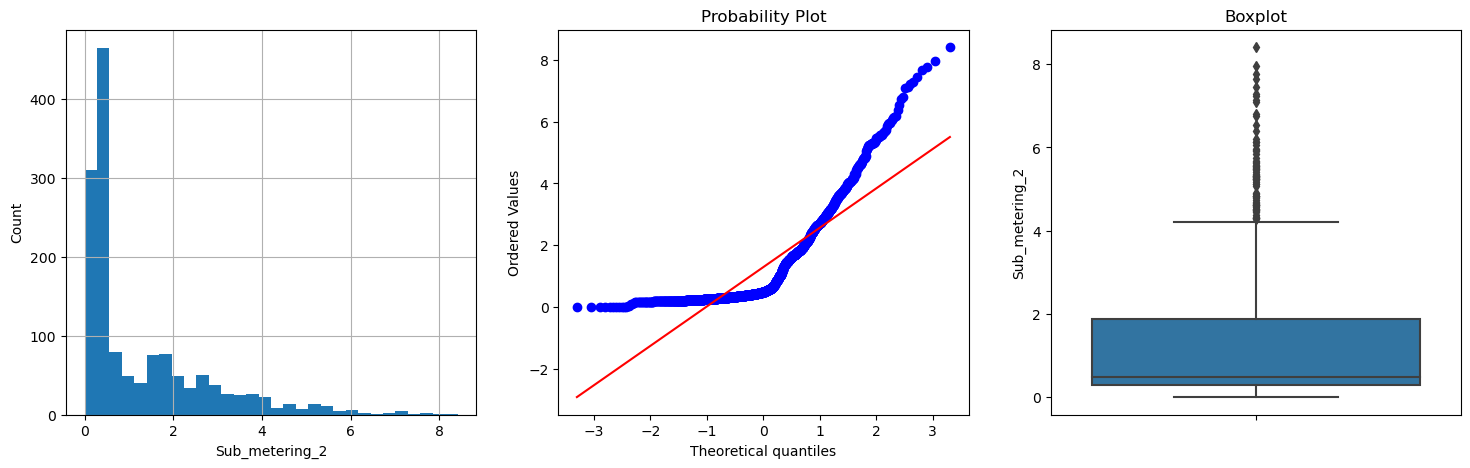

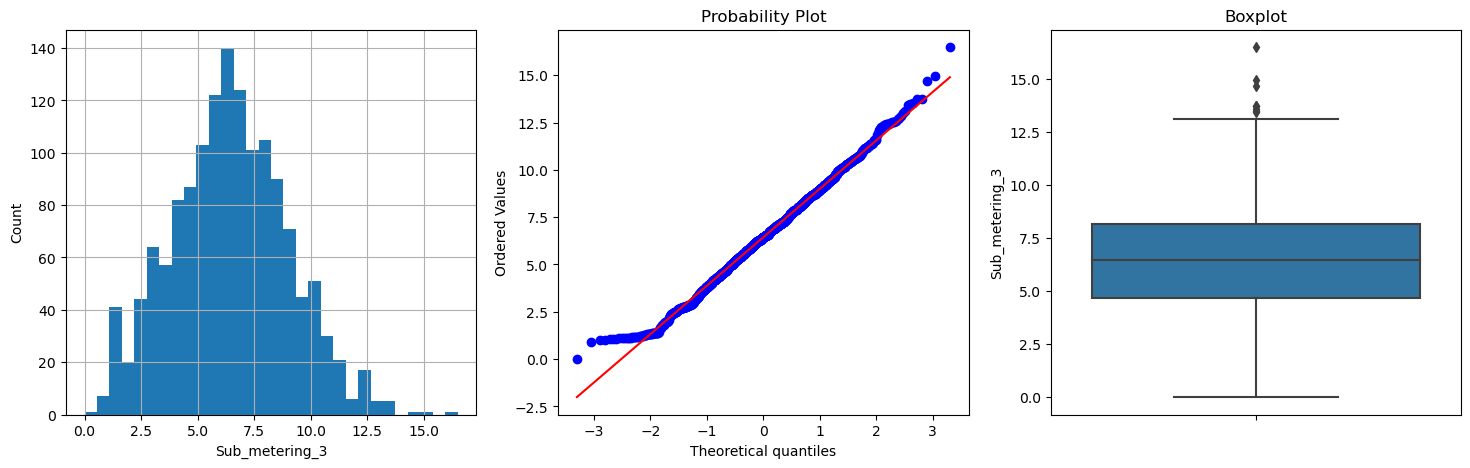

In [27]:
# See histograms, probability plots and box-plots after imputation of missing values

for var in feature_list:
    diagnostic_plots(df_daily_median, var)

We can see that after daily resampling some variables more or less have normal distribution but some have a skewed distribution. Maybe we'll need to make some transformations with variables before training. Transformations help to stabilize the variance.

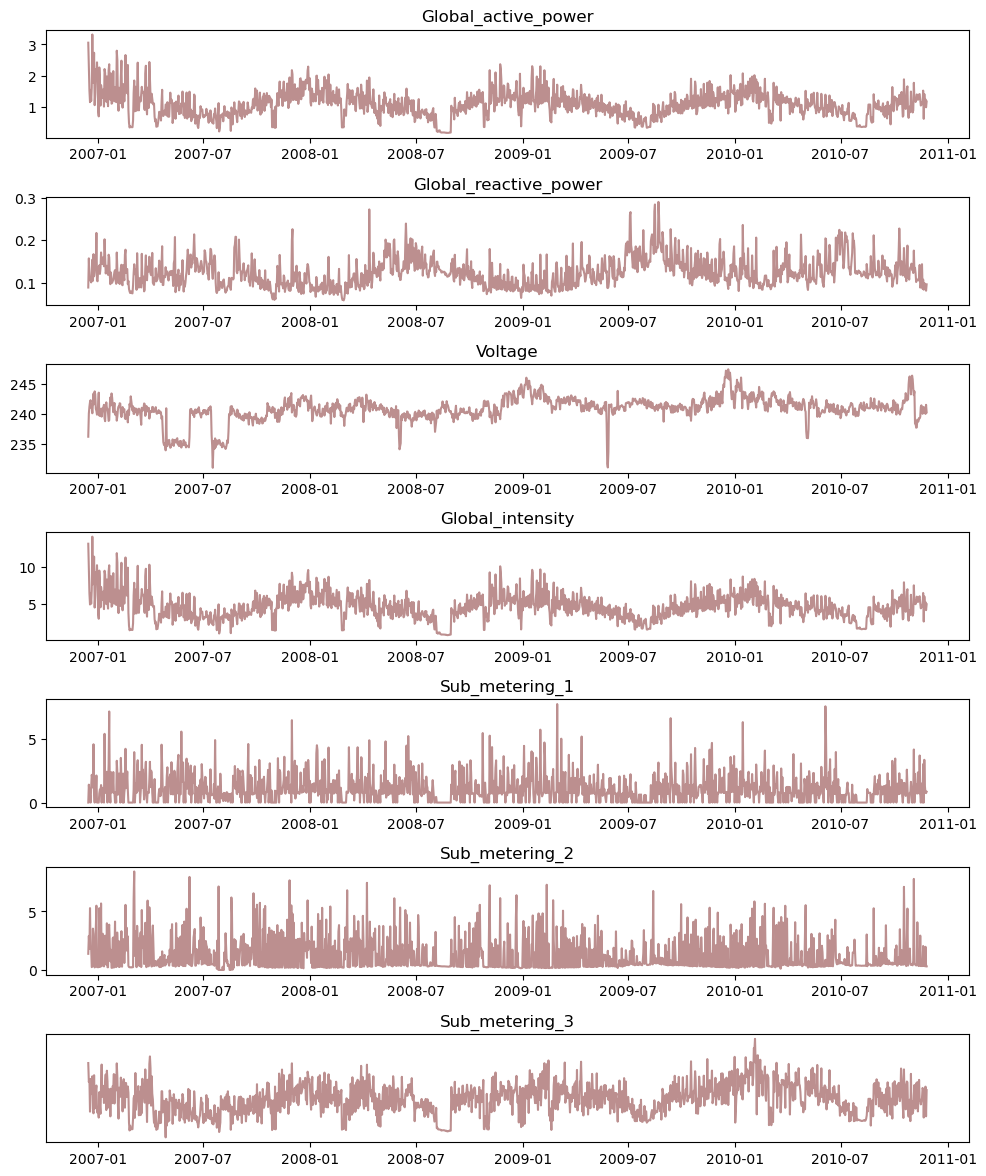

In [28]:
# Show line plot for each variable in resampled daily dataset

plt.figure(figsize = (10, 20))
for col in range(len(feature_list)):
    plt.subplot(len(df_daily_median.columns), 1, col + 1)
    name = feature_list[col]
    plt.plot(df_daily_median[name], color = 'rosybrown')
    plt.title(name, y = 1)
plt.tight_layout()
plt.yticks([])
plt.show()

From Jan to March we can see common pattern of increasing consumption of electricity and decreasing pattern over the summer, then increasing pattern in winter. It shows annual seasonal pattern in consumption. We can also notice that the values of the variables are very unstable, constantly changing.

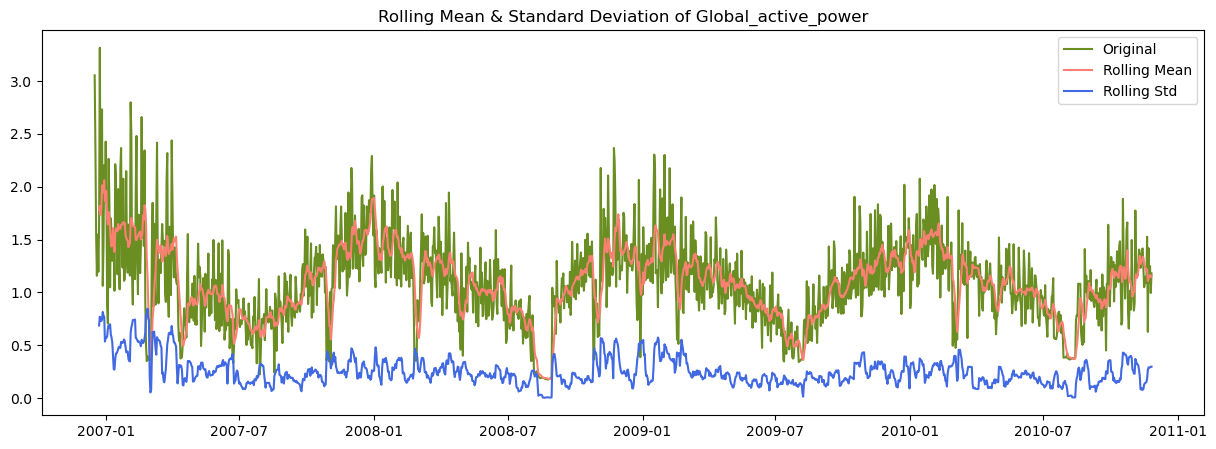

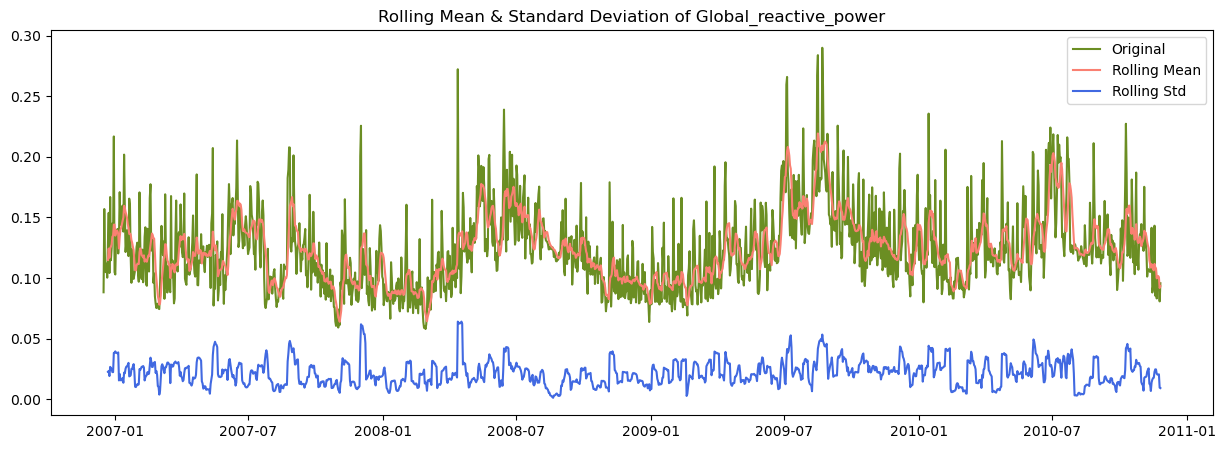

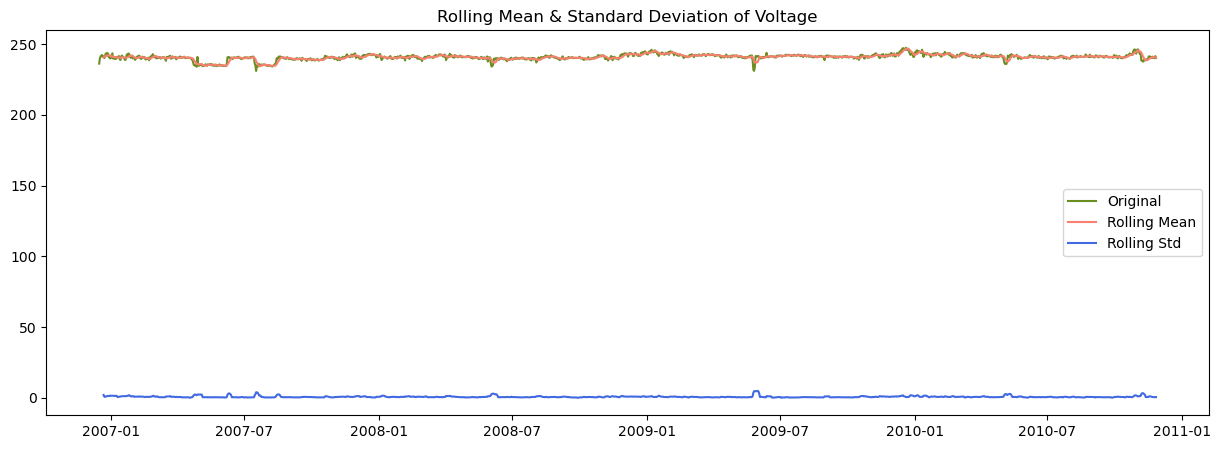

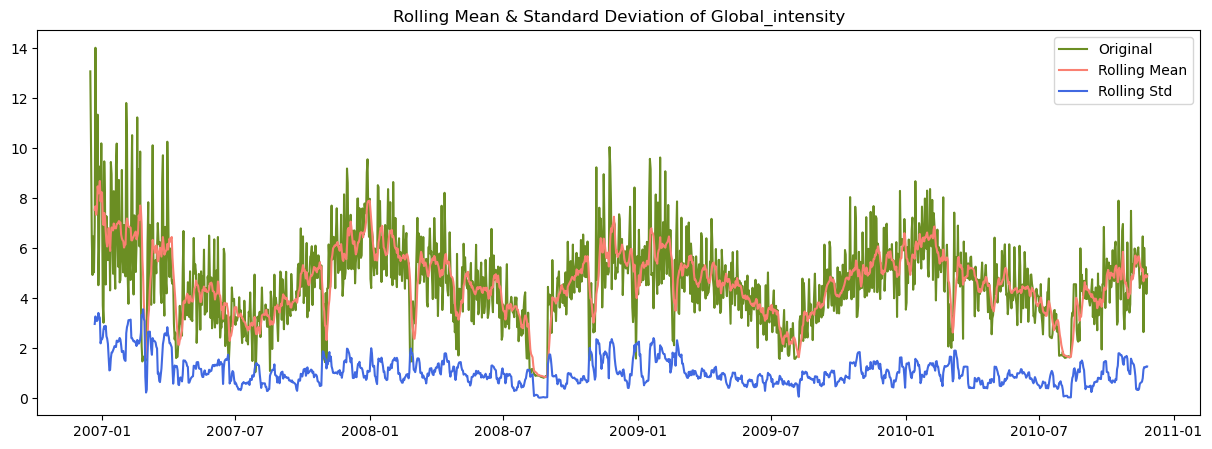

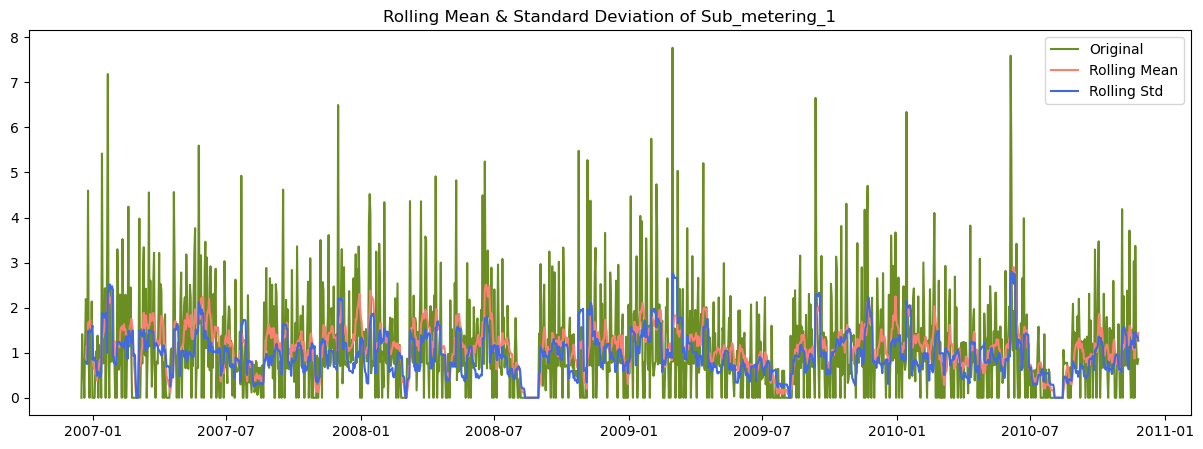

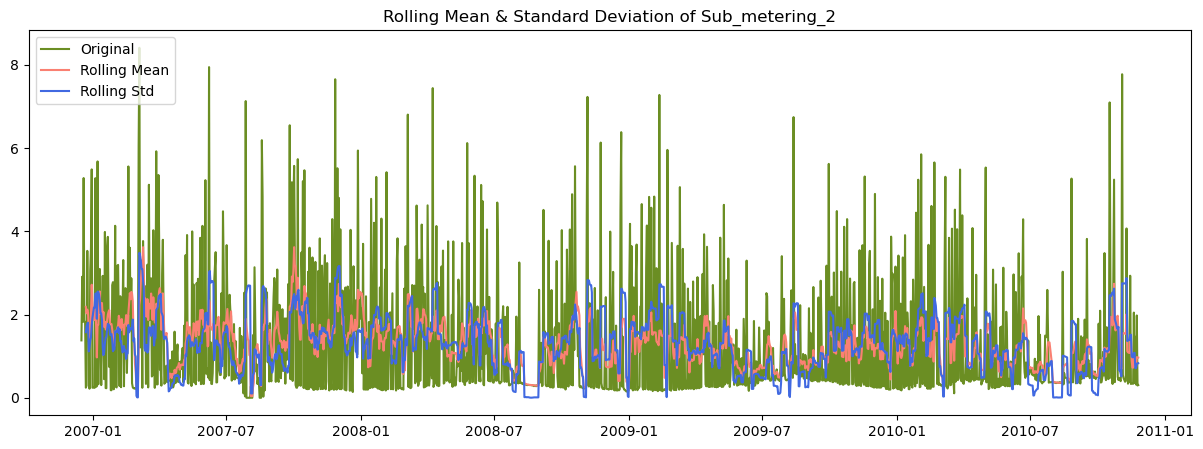

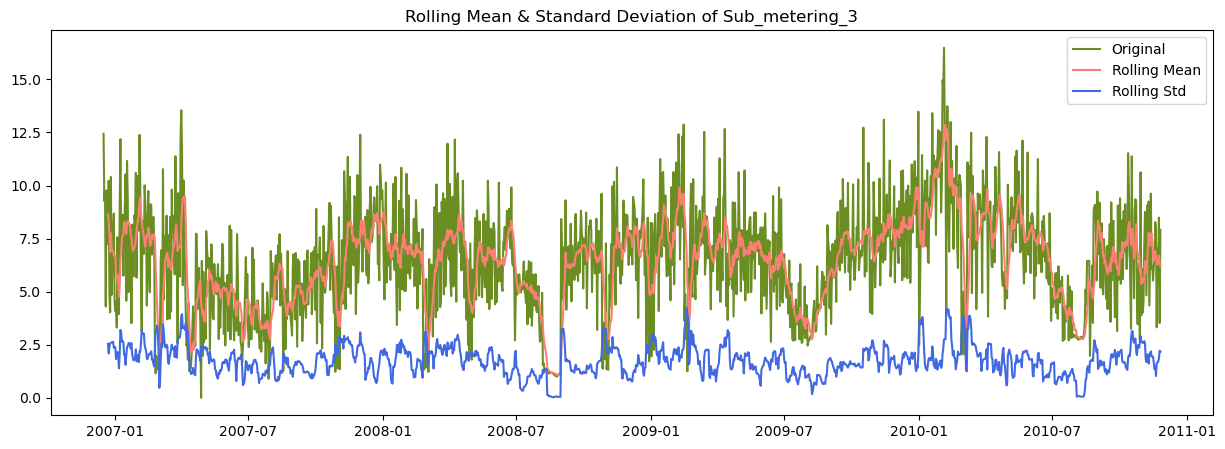

In [33]:
# Check rolling statistics

for var in feature_list:
    rolling_statistics(df_daily_median, var, 7)

We can see through plotting the moving average or moving variance how mean value and standard deviation change over time. We see that mean value and standard deviation are very changeable over the time. 

Stationary series has constant mean and variance over time. Rolling average and the rolling standard deviation of time series do not change over time. So, we have a non-stationary series.

In [34]:
# Stationarity Check
for var in feature_list:
    stationary_or_non_stationary(df_daily_median, var)

Results of Dickey-Fuller Test: Global_active_power
Test Statistic                   -1.160887
p-value                           0.224000
#Lags Used                       22.000000
Number of Observations Used    1419.000000
Critical Value (1%)              -2.567317
Critical Value (5%)              -1.941191
Critical Value (10%)             -1.616634
dtype: float64
 
*********************************************************
 
Results of Dickey-Fuller Test: Global_reactive_power
Test Statistic                   -0.914680
p-value                           0.322791
#Lags Used                       22.000000
Number of Observations Used    1419.000000
Critical Value (1%)              -2.567317
Critical Value (5%)              -1.941191
Critical Value (10%)             -1.616634
dtype: float64
 
*********************************************************
 
Results of Dickey-Fuller Test: Voltage
Test Statistic                   -0.080944
p-value                           0.656708
#Lags Used     

In statistics, the Dickey–Fuller test tests the null hypothesis that a unit root is present in an autoregressive model. The alternative hypothesis is different depending on which version of the test is used, but is usually stationarity or trend-stationarity.

Null Hypothesis (H0): It suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.

Alternate Hypothesis (H1): It suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

p-value > 0.05: Accept the null hypothesis (H0), the data has a unit root and is non-stationary.

p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

From this test we can see that our data has a unit root is non-stationary. In all tested features we received test statistic value is more than critical value at 1% and p-value > 0.05. From the above results, we will accept the null hypothesis H0 and say that the data has a unit root and is non-stationary. To make our series stationary, we need some transformations with our data.

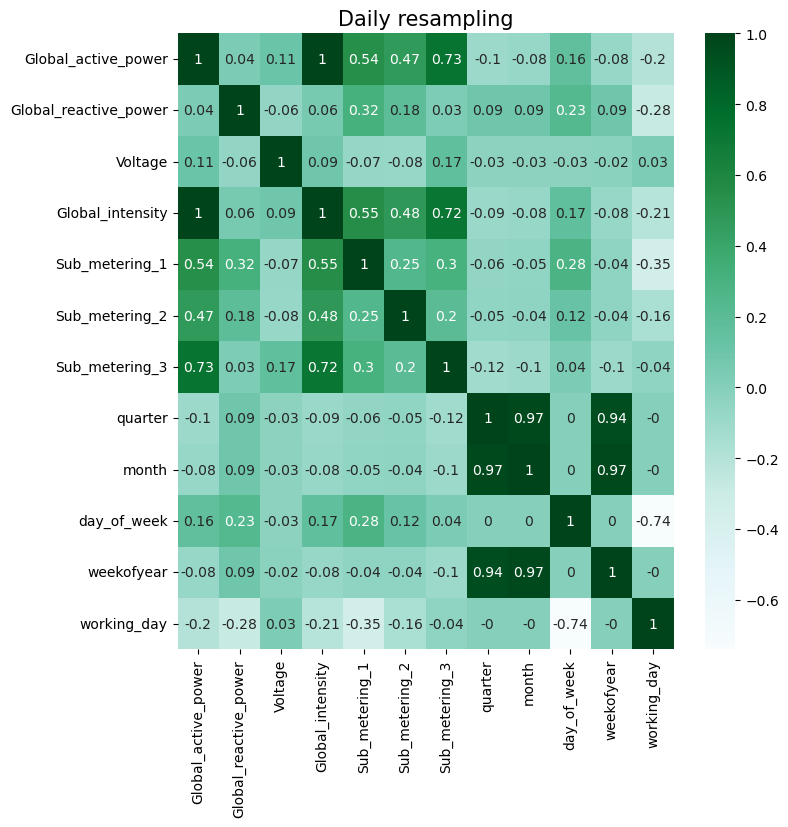

In [29]:
# Correlation after daily resampling. Check multicollinearity.

corr = df_daily_median.corr().round(2)
fig = plt.figure(figsize = (8, 8))
sns.heatmap(corr, annot = True, cmap = 'BuGn')
plt.title('Daily resampling', size = 15)
plt.show()

We see that 'Global_intensity' and 'Global_active_power' have strong correlation, so we need to drop 'Global_intensity'.

Also, new created features, such as 'quarter' and 'month' have very strong correlation.

'weekofyear' is strongly correlated with 'quarter' and 'month'.

So, we need to drop multicorrelated features before training

## Step 4. Data preprocessing

In [30]:
# Redefine df
# Drop multicorrelated variables

df_daily = df_daily_dates.drop(labels = ['Global_intensity', 
                                         'month', 
                                         'weekofyear'], axis = 1)

In [31]:
# Drop multicorrelated variable from our list with features
feature_list = feature_list.drop('Global_intensity')

In [32]:
# Check variables in list
feature_list

Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3'],
      dtype='object')

In [33]:
# Define pipeline to impute missing values, make transformation and capping outliers

pipe = Pipeline([
    ('imputation', MeanMedianImputer(imputation_method = 'median', variables = ['Global_active_power', 
                                                                                'Global_reactive_power', 
                                                                                'Voltage',
                                                                                'Sub_metering_1', 
                                                                                'Sub_metering_2', 
                                                                                'Sub_metering_3'])), 
    ('transformation', vt.PowerTransformer(variables = ['Global_active_power', 
                                                             'Global_reactive_power',
                                                             'Voltage', 
                                                             'Sub_metering_1',
                                                             'Sub_metering_2',
                                                             'Sub_metering_3'])), 
    ('winsorizer', Winsorizer(capping_method = 'iqr', 
                              tail = 'both', 
                              variables = ['Global_active_power',
                                           'Global_reactive_power',
                                           'Voltage',
                                           'Sub_metering_1',
                                           'Sub_metering_2',
                                           'Sub_metering_3']))
])

In [34]:
# Fit and transform on our dataset
df_daily = pipe.fit_transform(df_daily)

In [35]:
# Check df after transformation
df_daily

,Global_active_power,Global_reactive_power,Voltage,Sub_metering_1,Sub_metering_2,Sub_metering_3,quarter,day_of_week,working_day
dt,,,,,,,,,
2006-12-16,1.747419,0.296963,15.370223,0.000000,1.174218,3.526953,4,5,0
2006-12-17,1.534433,0.396167,15.494742,1.188194,1.705180,3.043778,4,6,0
2006-12-18,1.237107,0.335195,15.531635,0.859182,1.349125,3.120052,4,0,1
2006-12-19,1.075676,0.323760,15.556327,0.763308,2.297644,2.074481,4,1,1
2006-12-20,1.243245,0.334371,15.566248,0.000000,1.356056,3.125056,4,2,1
...,...,...,...,...,...,...,...,...,...
2010-11-22,1.190686,0.314415,15.498294,1.836172,1.210487,2.653090,4,0,1
2010-11-23,1.046667,0.308952,15.510497,1.139871,0.563964,2.299003,4,1,1
2010-11-24,1.116868,0.303292,15.492933,0.872417,1.406335,2.913570,4,2,1


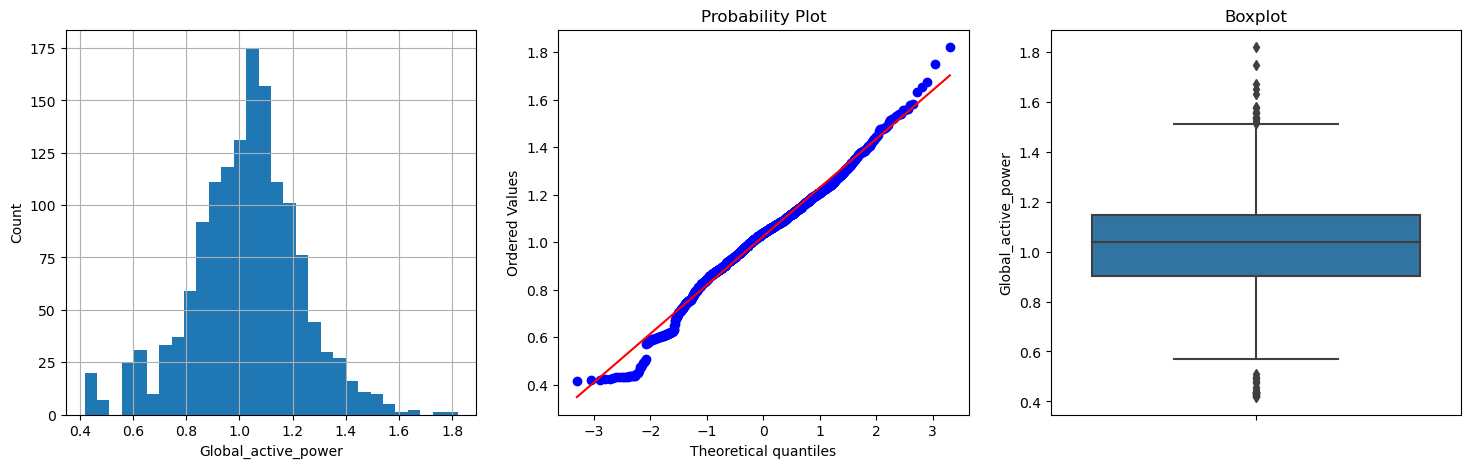

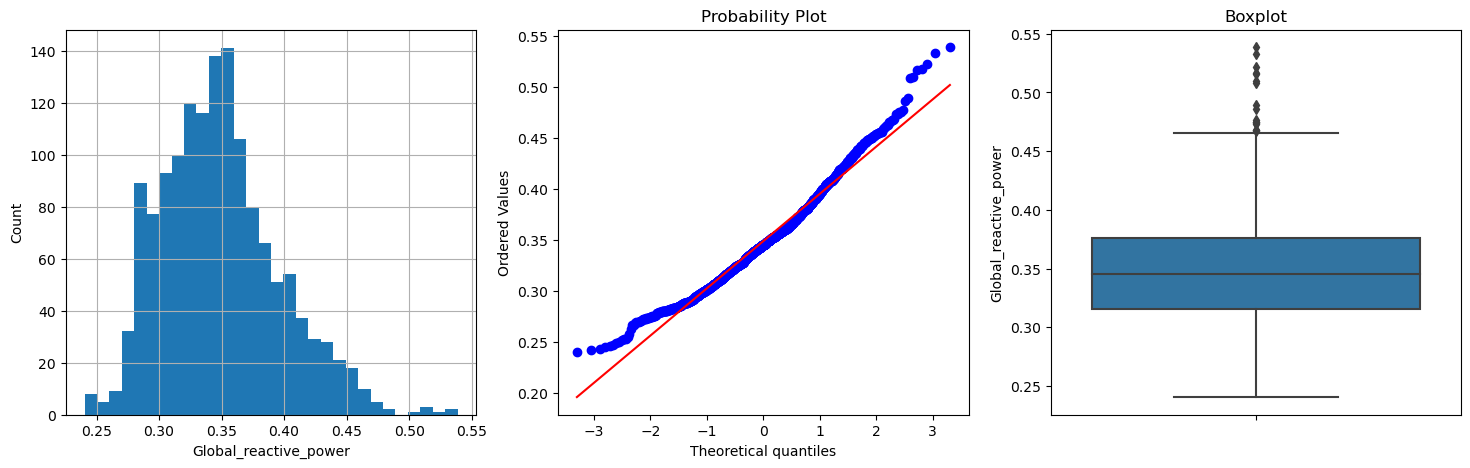

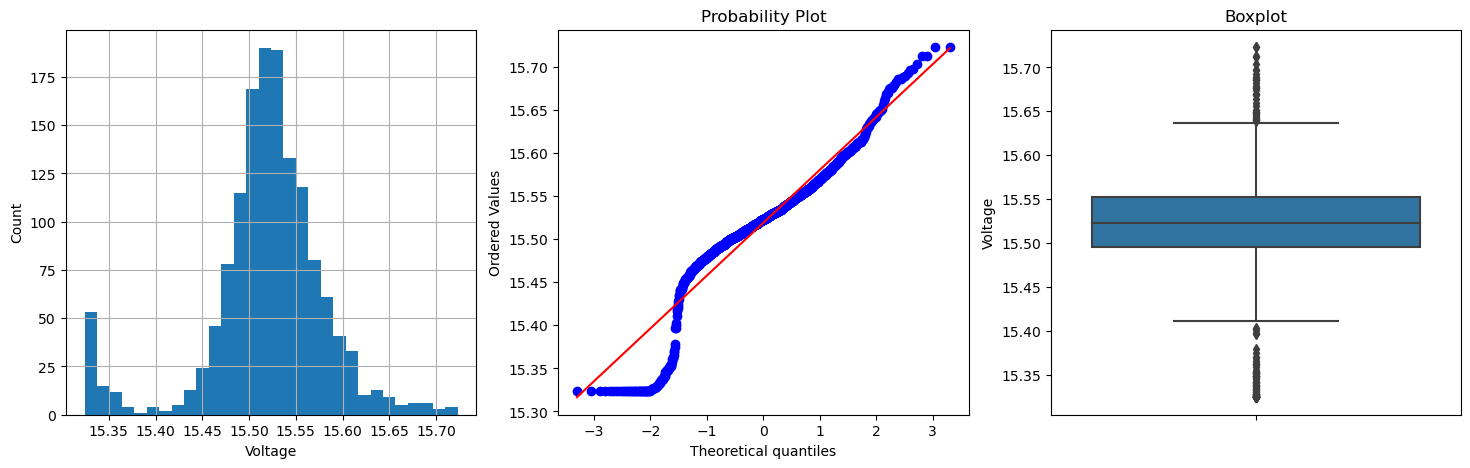

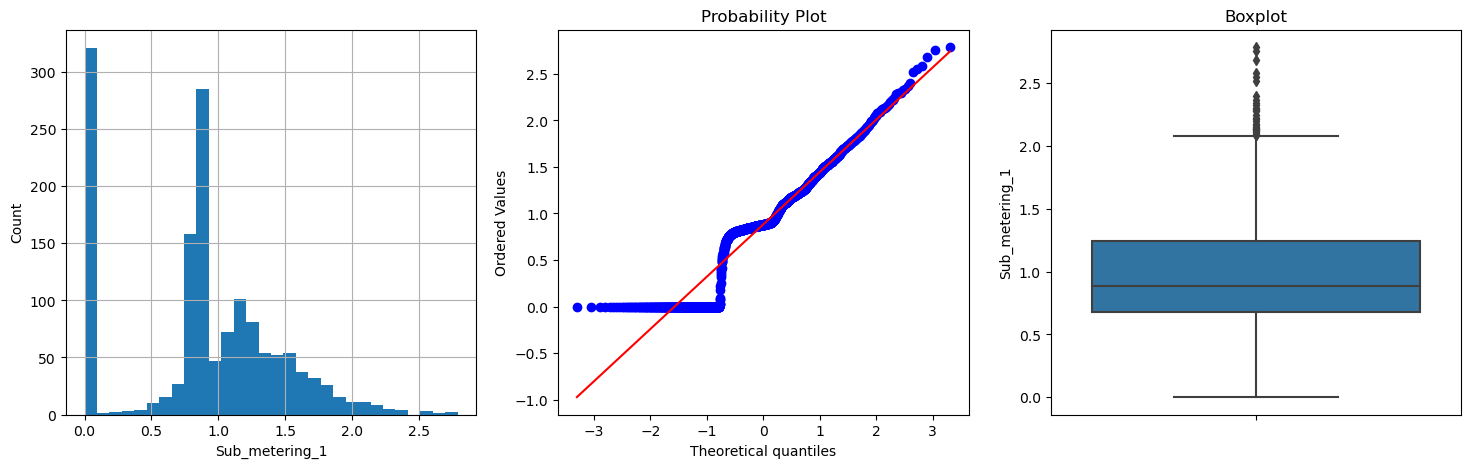

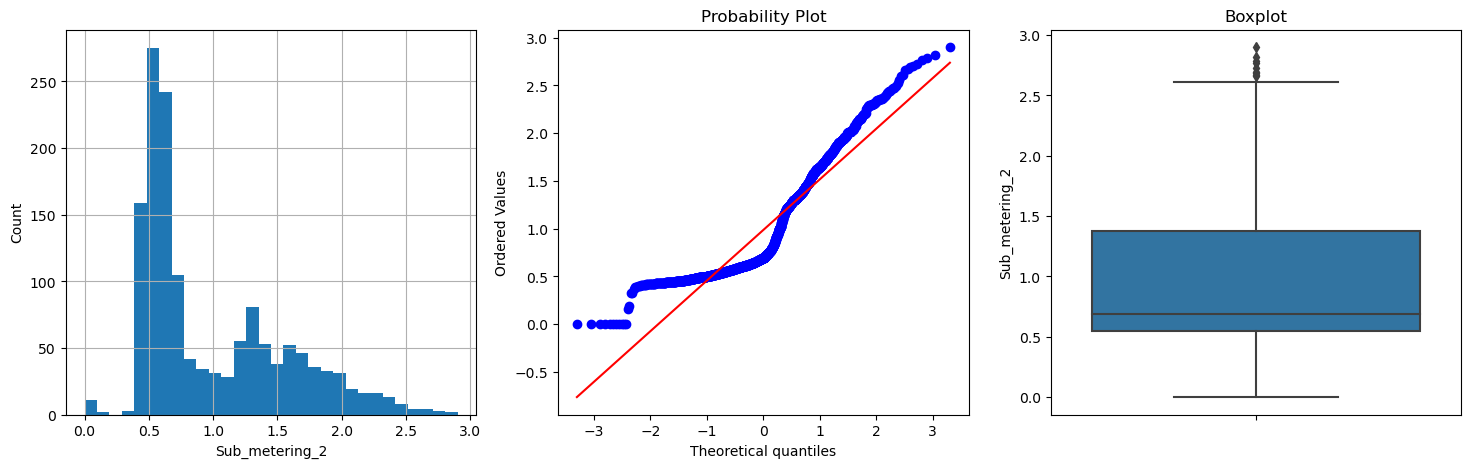

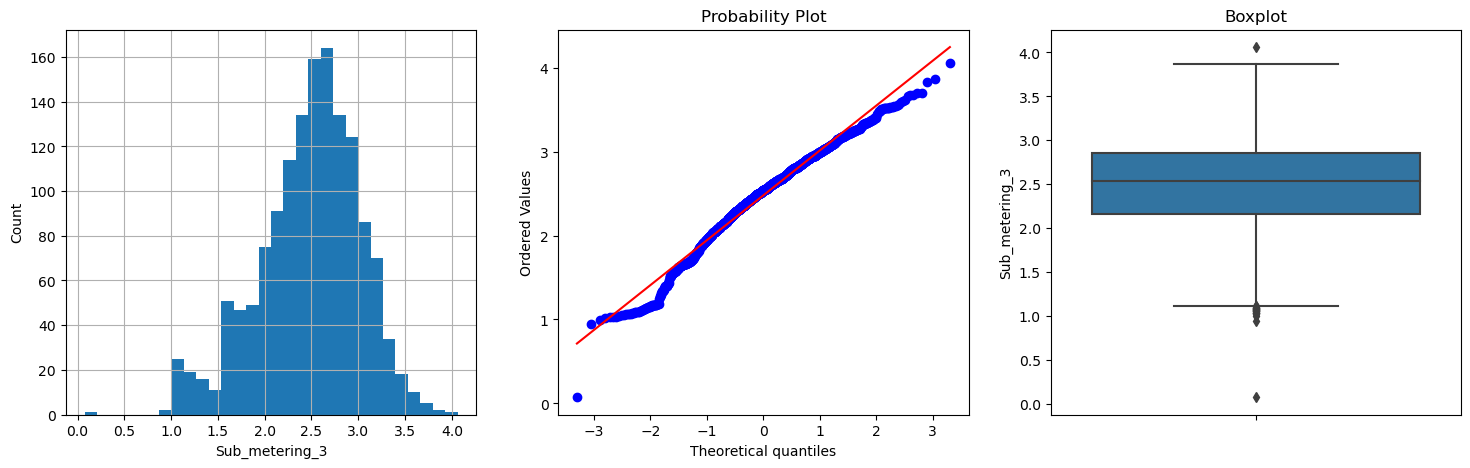

In [36]:
# Check how was changed the distribution
for var in feature_list:
    diagnostic_plots(df_daily, var)

In [39]:
# Make our series supervised. Create sequences in time.

def series_to_supervised(data, n_in = 1, n_out = 1, dropnan = True):

    n_vars = 1 if type(data) is list else data.shape[1]

    dff = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(i))
        names += [('var%d(t-%d)' %(j+1, i)) for j in range(n_vars)]
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(dff.shift(-1))
        if i == 0:
            names += [('var%d(t)' % (j +1)) for j in range(n_vars)]
        else:
            names +=[('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    # put it all together
    agg = pd.concat(cols, axis = 1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace = True)
    return agg

In [40]:
# Use previous 7 days to predict next day

reframed = series_to_supervised(df_daily, 7, 1)

reframed.head(10)

,var1(t-7),var2(t-7),var3(t-7),var4(t-7),var5(t-7),var6(t-7),var7(t-7),var8(t-7),var9(t-7),var1(t-6),...,var9(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t)
dt,,,,,,,,,,,,,,,,,,,,,
2006-12-23,1.747419,0.296963,15.370223,0.000000,1.174218,3.526953,4.0,5.0,0.0,1.534433,...,1.0,1.330730,0.322641,15.546300,1.087492,1.878608,2.187560,4.0,6.0,0.0
2006-12-24,1.534433,0.396167,15.494742,1.188194,1.705180,3.043778,4.0,6.0,0.0,1.237107,...,0.0,1.380197,0.408486,15.601280,2.144113,1.167262,2.006067,4.0,0.0,0.0
2006-12-25,1.237107,0.335195,15.531635,0.859182,1.349125,3.120052,4.0,0.0,1.0,1.075676,...,0.0,1.652883,0.338606,15.544306,0.868428,1.326283,3.225226,4.0,1.0,1.0
2006-12-26,1.075676,0.323760,15.556327,0.763308,2.297644,2.074481,4.0,1.0,1.0,1.243245,...,0.0,1.030359,0.352473,15.613051,0.000000,0.466964,2.201010,4.0,2.0,1.0
2006-12-27,1.243245,0.334371,15.566248,0.000000,1.356056,3.125056,4.0,2.0,1.0,1.092592,...,1.0,1.199722,0.380858,15.597062,1.237998,1.751785,2.524326,4.0,3.0,1.0
2006-12-28,1.092592,0.316630,15.525481,1.107880,1.350578,2.692001,4.0,3.0,1.0,1.275119,...,1.0,1.484735,0.369303,15.520029,0.932440,1.893336,2.804882,4.0,4.0,1.0
2006-12-29,1.275119,0.360272,15.530117,1.479255,0.493007,2.780263,4.0,4.0,1.0,1.820673,...,1.0,1.392734,0.465745,15.509374,1.461609,2.342538,2.945967,4.0,5.0,0.0
2006-12-30,1.820673,0.392172,15.496325,1.361423,0.543267,3.197873,4.0,5.0,0.0,1.330730,...,1.0,1.557731,0.323664,15.488595,0.000000,0.490889,2.124918,4.0,6.0,0.0
2006-12-31,1.330730,0.322641,15.546300,1.087492,1.878608,2.187560,4.0,6.0,0.0,1.380197,...,0.0,1.381677,0.320769,15.496096,0.000000,0.494413,2.020726,1.0,0.0,0.0


In [41]:
# drop columns I don't want to predict
reframed.drop(reframed.columns[-8:], axis = 1, inplace = True)
reframed.head()

,var1(t-7),var2(t-7),var3(t-7),var4(t-7),var5(t-7),var6(t-7),var7(t-7),var8(t-7),var9(t-7),var1(t-6),...,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var1(t)
dt,,,,,,,,,,,,,,,,,,,,,
2006-12-23,1.747419,0.296963,15.370223,0.000000,1.174218,3.526953,4.0,5.0,0.0,1.534433,...,1.275119,0.360272,15.530117,1.479255,0.493007,2.780263,4.0,4.0,1.0,1.330730
2006-12-24,1.534433,0.396167,15.494742,1.188194,1.705180,3.043778,4.0,6.0,0.0,1.237107,...,1.820673,0.392172,15.496325,1.361423,0.543267,3.197873,4.0,5.0,0.0,1.380197
2006-12-25,1.237107,0.335195,15.531635,0.859182,1.349125,3.120052,4.0,0.0,1.0,1.075676,...,1.330730,0.322641,15.546300,1.087492,1.878608,2.187560,4.0,6.0,0.0,1.652883
2006-12-26,1.075676,0.323760,15.556327,0.763308,2.297644,2.074481,4.0,1.0,1.0,1.243245,...,1.380197,0.408486,15.601280,2.144113,1.167262,2.006067,4.0,0.0,0.0,1.030359
2006-12-27,1.243245,0.334371,15.566248,0.000000,1.356056,3.125056,4.0,2.0,1.0,1.092592,...,1.652883,0.338606,15.544306,0.868428,1.326283,3.225226,4.0,1.0,1.0,1.199722


In [42]:
# Split into train and test sets

values = reframed.values

n_train_time = 365 * 3

train = values[:n_train_time, :]
test = values[n_train_time:, :]

train_X, train_y = train[:, :-1], train[:, -1]

test_X, test_y = test[:, :-1], test[:, -1]

In [43]:
# Normalize the variables

scaler_X = MinMaxScaler(feature_range = (0, 1))
scaler_y = MinMaxScaler(feature_range = (0, 1))

train_X = scaler_X.fit_transform(train_X)
test_X = scaler_X.transform(test_X)

train_y = train_y.reshape(-1, 1)
test_y = test_y.reshape(-1, 1)

train_y = scaler_y.fit_transform(train_y)
test_y = scaler_y.transform(test_y)

In [44]:
# Reshape in 3D format

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1095, 1, 63) (1095, 1) (339, 1, 63) (339, 1)


In [132]:
# Create lists with results of each metrics

model_name = []

rmse_train_scores = []
mae_train_scores = []
mse_train_scores = []

rmse_test_scores = []
mae_test_scores = []
mse_test_scores = []

In [46]:
# Define callbacks

# Stop training if val_loss don't improve
early_stopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 10)

# Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 2, min_lr = 1e-15)

## Step 5. Model training

1. Vanilla LSTM
2. Stacked LSTM
3. Bidirectional LSTM
4. CNN-LSTM

## Vanilla LSTM

In [85]:
# Define model
lstm = Sequential()
lstm.add(LSTM(256, input_shape = (train_X.shape[1], train_X.shape[2])))
lstm.add(Dropout(0.3))
lstm.add(Dense(1))
lstm.compile(loss = keras.losses.Huber(), optimizer = RMSprop(learning_rate = 1e-3))

history = lstm.fit(
    train_X, 
    train_y, 
    epochs = 200, 
    batch_size = 32, 
    validation_split = 0.2, 
    verbose = 1, 
    shuffle = False, 
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/200


2023-02-16 22:38:56.493502: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-16 22:38:56.607333: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 4/28 [===>..........................] - ETA: 0s - loss: 0.0707 

2023-02-16 22:38:56.696986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 2s 26ms/step - loss: 0.0196 - val_loss: 0.0139 - lr: 0.0010
Epoch 2/200
 1/28 [>.............................] - ETA: 0s - loss: 0.0161

2023-02-16 22:38:57.378752: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-16 22:38:57.415071: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 0s 12ms/step - loss: 0.0124 - val_loss: 0.0096 - lr: 0.0010
Epoch 3/200
28/28 [==============================] - 0s 11ms/step - loss: 0.0113 - val_loss: 0.0076 - lr: 0.0010
Epoch 4/200
28/28 [==============================] - 0s 12ms/step - loss: 0.0106 - val_loss: 0.0063 - lr: 0.0010
Epoch 5/200
28/28 [==============================] - 0s 12ms/step - loss: 0.0101 - val_loss: 0.0056 - lr: 0.0010
Epoch 6/200
28/28 [==============================] - 0s 11ms/step - loss: 0.0097 - val_loss: 0.0050 - lr: 0.0010
Epoch 7/200
28/28 [==============================] - 0s 11ms/step - loss: 0.0094 - val_loss: 0.0046 - lr: 0.0010
Epoch 8/200
28/28 [==============================] - 0s 11ms/step - loss: 0.0091 - val_loss: 0.0043 - lr: 0.0010
Epoch 9/200
28/28 [==============================] - 0s 11ms/step - loss: 0.0088 - val_loss: 0.0041 - lr: 0.0010
Epoch 10/200
28/28 [==============================] - 0s 12ms/step - loss: 0.0086 - val_loss: 0.0040 - lr: 0

In [48]:
lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 256)               327680    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 327,937
Trainable params: 327,937
Non-trainable params: 0
_________________________________________________________________


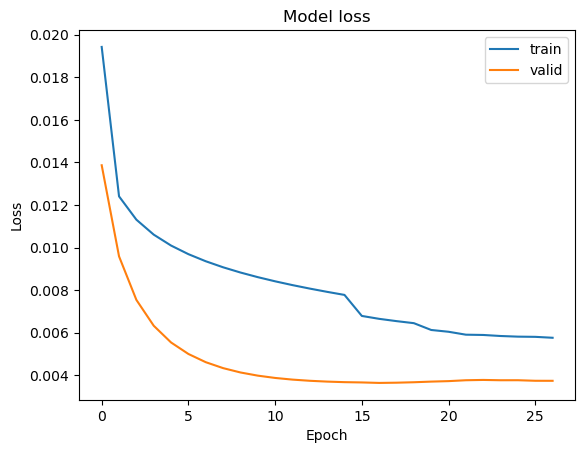

In [50]:
# Visualize model losses during training
plot_model_losses(history)

We see that train and validation losses decreased and training stopped at epoch 27.

11/11 [==============================] - 0s 3ms/step
 
Train Mean Absolute Error: 0.106
Train Mean Squared Error: 0.020
Train RMSE: 0.142
 
Test Mean Absolute Error: 0.103
Test Mean Squared Error: 0.019
Test RMSE: 0.136


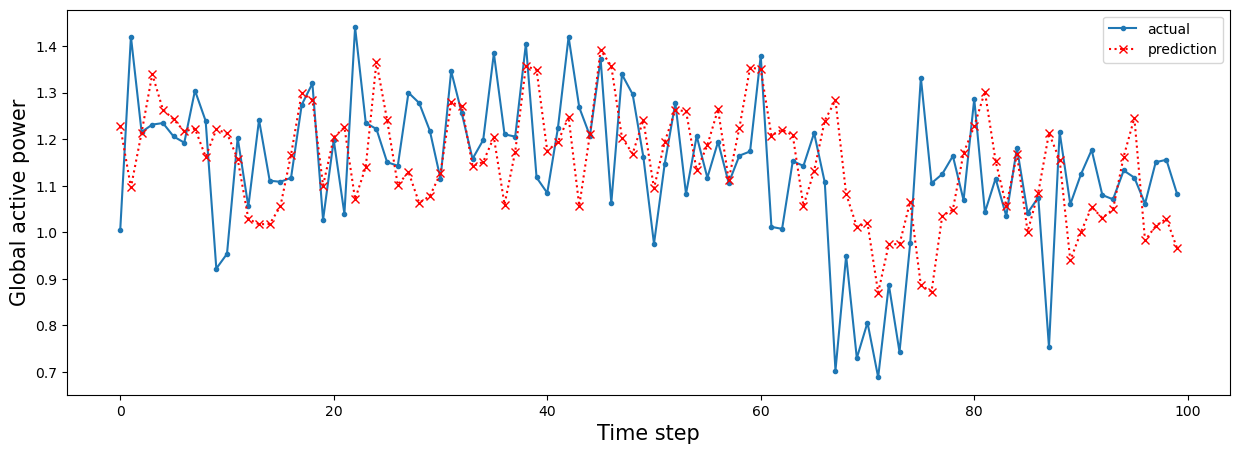

In [133]:
# Print results and show a plot with predicted and actual values 
model_name.append('Vanilla LSTM')
model_predict_show_scores_and_plot(lstm, train_X, test_X, train_y, test_y)

From metrics we can see that there are not mush differences between predicted errors in train and test sets. From plot we can see that the model most often failed to predict extremely low or high values. But the model was able to learn the pattern of volatility in consumption.

## Stacked LSTMs

In [89]:
# Define model

stacked_lstm = Sequential()
stacked_lstm.add(LSTM(256, return_sequences = True, input_shape = (train_X.shape[1], train_X.shape[2])))
stacked_lstm.add(Dropout(0.3))
stacked_lstm.add(LSTM(256))
stacked_lstm.add(Dropout(0.3))
stacked_lstm.add(Dense(1))
stacked_lstm.compile(loss = keras.losses.Huber(), optimizer = RMSprop(learning_rate = 1e-3))

history = stacked_lstm.fit(
    train_X, 
    train_y, 
    epochs = 200, 
    batch_size = 32, 
    validation_split = 0.2, 
    verbose = 1, 
    shuffle = False, 
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/200


2023-02-16 22:39:49.036714: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-16 22:39:49.215651: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-16 22:39:49.271502: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-16 22:39:49.373768: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-16 22:39:49.465396: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - ETA: 0s - loss: 0.0243

2023-02-16 22:39:50.482727: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-16 22:39:50.543523: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-16 22:39:50.581947: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 3s 43ms/step - loss: 0.0243 - val_loss: 0.0097 - lr: 0.0010
Epoch 2/200
28/28 [==============================] - 0s 18ms/step - loss: 0.0123 - val_loss: 0.0088 - lr: 0.0010
Epoch 3/200
28/28 [==============================] - 0s 16ms/step - loss: 0.0114 - val_loss: 0.0078 - lr: 0.0010
Epoch 4/200
28/28 [==============================] - 0s 17ms/step - loss: 0.0108 - val_loss: 0.0070 - lr: 0.0010
Epoch 5/200
28/28 [==============================] - 0s 17ms/step - loss: 0.0103 - val_loss: 0.0063 - lr: 0.0010
Epoch 6/200
28/28 [==============================] - 0s 17ms/step - loss: 0.0098 - val_loss: 0.0057 - lr: 0.0010
Epoch 7/200
28/28 [==============================] - 0s 16ms/step - loss: 0.0094 - val_loss: 0.0052 - lr: 0.0010
Epoch 8/200
28/28 [==============================] - 0s 17ms/step - loss: 0.0090 - val_loss: 0.0048 - lr: 0.0010
Epoch 9/200
28/28 [==============================] - 0s 17ms/step - loss: 0.0087 - val_loss: 0.0045 - lr: 0.

In [90]:
stacked_lstm.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 1, 256)            327680    
                                                                 
 dropout_4 (Dropout)         (None, 1, 256)            0         
                                                                 
 lstm_5 (LSTM)               (None, 256)               525312    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 257       
                                                                 
Total params: 853,249
Trainable params: 853,249
Non-trainable params: 0
_________________________________________________________________


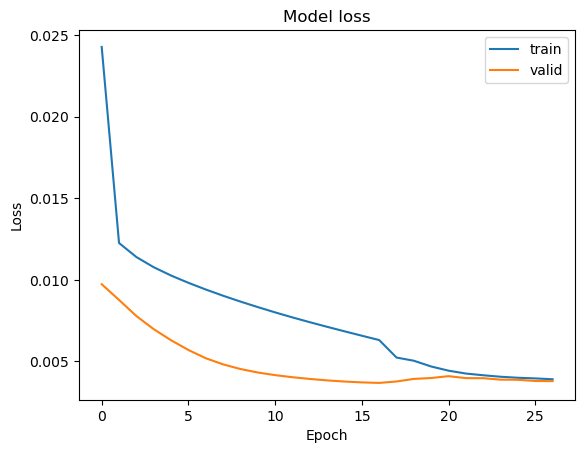

In [91]:
# Plot train & validation losses
plot_model_losses(history)

At the end of training at epoch 25, the losses converged.

11/11 [==============================] - 0s 4ms/step
 
Train Mean Absolute Error: 0.106
Train Mean Squared Error: 0.020
Train RMSE: 0.142
 
Test Mean Absolute Error: 0.102
Test Mean Squared Error: 0.018
Test RMSE: 0.136


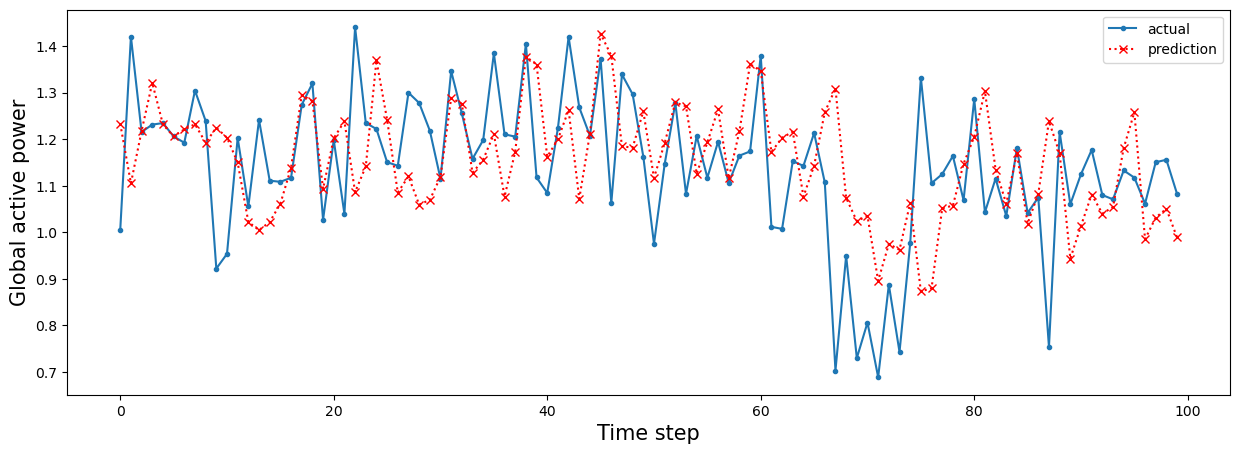

In [134]:
# Print results and show a plot with predicted and actual values 
model_name.append('Stacked LSTM')
model_predict_show_scores_and_plot(stacked_lstm, train_X, test_X, train_y, test_y)

It can be seen from the metrics that there are no big differences between the predicted errors in the training and test sets. And similiarly, we can see that the model most often failed to predict extremely low or high values.

## Bidirectional LSTM

In [97]:
# Define model
bi_lstm = Sequential()
bi_lstm.add(Bidirectional(LSTM(128, input_shape = (train_X.shape[1], train_X.shape[2]))))
bi_lstm.add(Dropout(0.3))
bi_lstm.add(Dense(1))
bi_lstm.compile(loss = keras.losses.Huber(), optimizer = RMSprop(learning_rate = 1e-3))

history = bi_lstm.fit(
    train_X, 
    train_y, 
    epochs = 200, 
    batch_size = 32, 
    validation_split = 0.2, 
    verbose = 1, 
    shuffle = False, 
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/200


2023-02-16 22:43:30.695921: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-16 22:43:30.894579: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-16 22:43:30.904573: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-16 22:43:31.063882: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-16 22:43:31.077377: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - ETA: 0s - loss: 0.0212

2023-02-16 22:43:32.531516: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-16 22:43:32.593401: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-16 22:43:32.600366: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 3s 56ms/step - loss: 0.0212 - val_loss: 0.0106 - lr: 0.0010
Epoch 2/200
28/28 [==============================] - 0s 17ms/step - loss: 0.0132 - val_loss: 0.0082 - lr: 0.0010
Epoch 3/200
28/28 [==============================] - 0s 17ms/step - loss: 0.0117 - val_loss: 0.0068 - lr: 0.0010
Epoch 4/200
28/28 [==============================] - 0s 17ms/step - loss: 0.0108 - val_loss: 0.0059 - lr: 0.0010
Epoch 5/200
28/28 [==============================] - 0s 16ms/step - loss: 0.0102 - val_loss: 0.0053 - lr: 0.0010
Epoch 6/200
28/28 [==============================] - 0s 17ms/step - loss: 0.0097 - val_loss: 0.0049 - lr: 0.0010
Epoch 7/200
28/28 [==============================] - 0s 17ms/step - loss: 0.0093 - val_loss: 0.0045 - lr: 0.0010
Epoch 8/200
28/28 [==============================] - 0s 16ms/step - loss: 0.0090 - val_loss: 0.0043 - lr: 0.0010
Epoch 9/200
28/28 [==============================] - 0s 16ms/step - loss: 0.0087 - val_loss: 0.0041 - lr: 0.

In [94]:
bi_lstm.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 256)              196608    
 l)                                                              
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 196,865
Trainable params: 196,865
Non-trainable params: 0
_________________________________________________________________


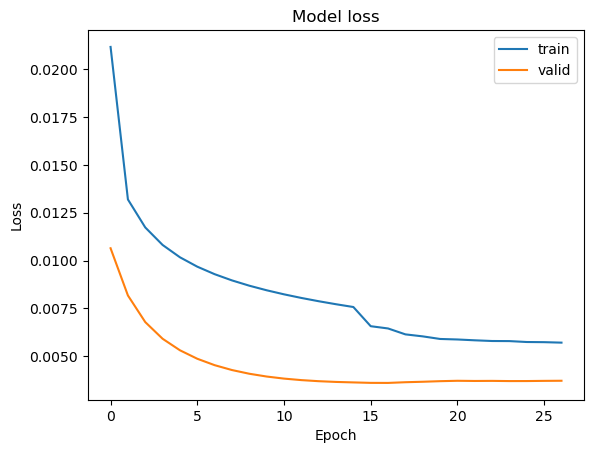

In [98]:
# Plot train & validation losses
plot_model_losses(history)

We see that train and validation losses decreased and training stopped at epoch 28.

11/11 [==============================] - 0s 6ms/step
 
Train Mean Absolute Error: 0.106
Train Mean Squared Error: 0.020
Train RMSE: 0.141
 
Test Mean Absolute Error: 0.102
Test Mean Squared Error: 0.018
Test RMSE: 0.135


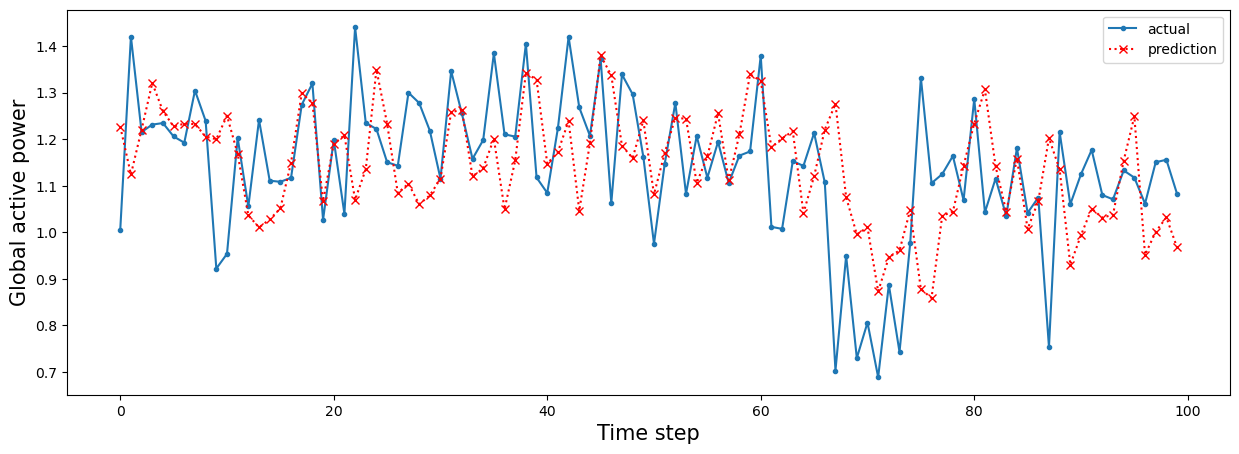

In [135]:
# Print results and show a plot with predicted and actual values 
model_name.append('Bidirectional LSTM')
model_predict_show_scores_and_plot(bi_lstm, train_X, test_X, train_y, test_y)

It can be seen from the metrics that there are no big differences between the predicted errors in the training and test sets. And similiarly, we can see that the model most often failed to predict extremely low or high values.

## CNN-LSTM(Hybrid LSTM) for Time Series Forecasting

In [110]:
# Reshape from [samples, timesteps, features] into [samples, subsequences, timesteps, features].

subsequences = 1
timesteps = train_X.shape[2]//subsequences

train_X_sub = train_X.reshape((train_X.shape[0], subsequences, timesteps, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], subsequences, timesteps, test_X.shape[1]))
print('Train set shape', train_X_sub.shape)
print('Test set shape', test_X.shape)

Train set shape (1095, 1, 63, 1)
Test set shape (339, 1, 63, 1)


In [111]:
# Define model
cnn_lstm = Sequential()
cnn_lstm.add(TimeDistributed(Conv1D(filters =128, 
                                    kernel_size=2, 
                                    activation='relu', 
                                    padding = 'same'), 
                                    input_shape=(None, train_X_sub.shape[2], train_X_sub.shape[3])))
cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2, strides = 2)))
cnn_lstm.add(TimeDistributed(Flatten()))
cnn_lstm.add(LSTM(100))
cnn_lstm.add(Dropout(0.3))
cnn_lstm.add(Dense(1))
cnn_lstm.compile(loss = keras.losses.Huber(), optimizer = RMSprop(learning_rate = 1e-3))

In [102]:
cnn_lstm.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, None, 63, 128)    384       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, None, 31, 128)    0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, None, 3968)       0         
 tributed)                                                       
                                                                 
 lstm_8 (LSTM)               (None, 100)               1627600   
                                                                 
 dropout_8 (Dropout)         (None, 100)               0         
                                                      

In [112]:
# Fit the model
history = cnn_lstm.fit(train_X_sub, train_y, 
                       validation_split = 0.2,
                       epochs = 200,
                       batch_size = 16, 
                       verbose = 1, 
                       callbacks = [early_stopping, reduce_lr])

Epoch 1/200


2023-02-16 22:50:42.034811: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-16 22:50:42.169418: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/55 [..............................] - ETA: 1:03 - loss: 0.1560

2023-02-16 22:50:42.347088: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


55/55 [==============================] - ETA: 0s - loss: 0.0271

2023-02-16 22:50:44.007000: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-16 22:50:44.062722: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


55/55 [==============================] - 3s 33ms/step - loss: 0.0271 - val_loss: 0.0058 - lr: 0.0010
Epoch 2/200
55/55 [==============================] - 1s 15ms/step - loss: 0.0122 - val_loss: 0.0143 - lr: 0.0010
Epoch 3/200
55/55 [==============================] - 1s 14ms/step - loss: 0.0113 - val_loss: 0.0040 - lr: 0.0010
Epoch 4/200
55/55 [==============================] - 1s 14ms/step - loss: 0.0102 - val_loss: 0.0040 - lr: 0.0010
Epoch 5/200
55/55 [==============================] - 1s 14ms/step - loss: 0.0093 - val_loss: 0.0077 - lr: 0.0010
Epoch 6/200
55/55 [==============================] - 1s 14ms/step - loss: 0.0082 - val_loss: 0.0040 - lr: 5.0000e-04
Epoch 7/200
55/55 [==============================] - 1s 14ms/step - loss: 0.0081 - val_loss: 0.0074 - lr: 5.0000e-04
Epoch 8/200
55/55 [==============================] - 1s 14ms/step - loss: 0.0074 - val_loss: 0.0038 - lr: 2.5000e-04
Epoch 9/200
55/55 [==============================] - 1s 14ms/step - loss: 0.0072 - val_loss: 0.0

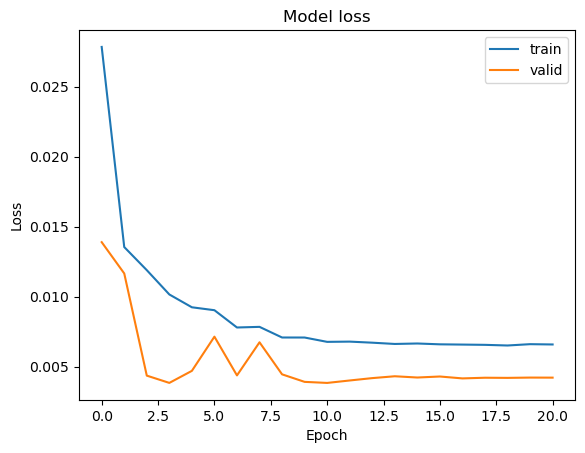

In [104]:
# Plot train & validation losses
plot_model_losses(history)

At the beginning of the training, the validation losses jumped a little, but by the end of the training they steadily decreased with training losses

11/11 [==============================] - 0s 9ms/step


2023-02-16 23:00:59.832572: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-16 23:00:59.880904: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 
Train Mean Absolute Error: 0.104
Train Mean Squared Error: 0.019
Train RMSE: 0.139
 
Test Mean Absolute Error: 0.100
Test Mean Squared Error: 0.018
Test RMSE: 0.135


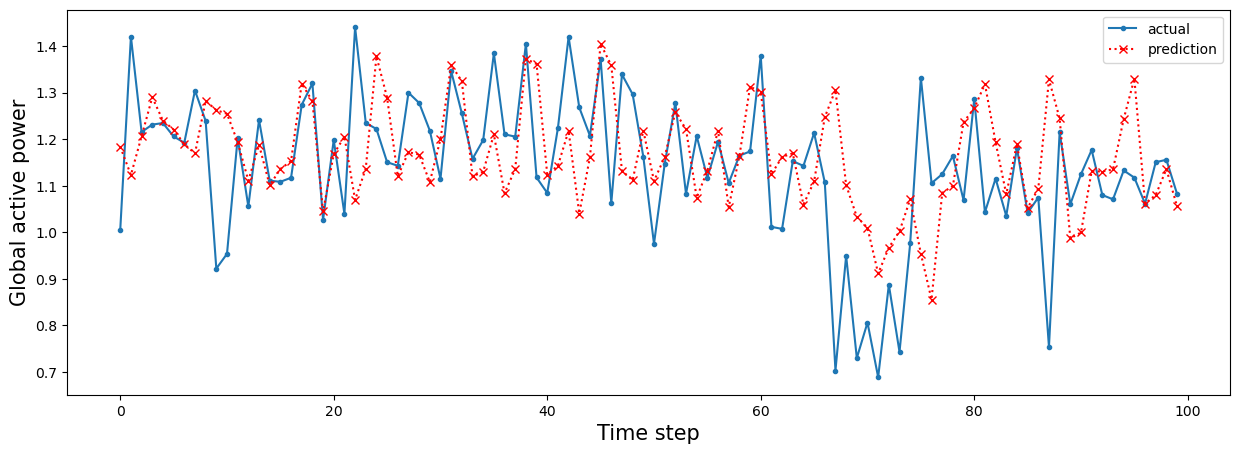

In [136]:
# Print results and show a plot with predicted and actual values 

model_name.append('CNN-LSTM')
model_predict_show_scores_and_plot(cnn_lstm, train_X_sub, test_X, train_y, test_y)

This model has the lowest errors of all the previous ones.
Similiarly, we can see that the model most often failed to predict extremely low or high values.

In [137]:
# Create DataFrame with models' scores

results = pd.DataFrame({'Model': model_name, 
                             'mae_train': mae_train_scores, 
                             'mae_test': mae_test_scores, 
                             'mse_train': mse_train_scores,
                             'mse_test': mse_test_scores,
                             'rmse_train': rmse_train_scores,
                             'rmse_test': rmse_test_scores
                             })


results.sort_values(by = 'rmse_test', ascending = False)

,Model,mae_train,mae_test,mse_train,mse_test,rmse_train,rmse_test
0,Vanilla LSTM,0.106,0.103,0.020,0.019,0.142,0.136
1,Stacked LSTM,0.106,0.102,0.020,0.018,0.142,0.136
2,Bidirectional LSTM,0.106,0.102,0.020,0.018,0.141,0.135
3,CNN-LSTM,0.104,0.100,0.019,0.018,0.139,0.135


CNN-LSTM model has the lowest error values. The mean absolute error in predicting the average consumption of electricity for the next day is 100 watts.

## Conclusion

Power consumption dataset contains 7 features such as global active power, total reactive power, average voltage,  active energy for kitchen, laundry and climate control systems consumed by the household. These data were collected every minute, beginning in 2006.  

In this project I've dealed with daily predictions, so I've started by sub-sampling the data from 1-minute intervals to 1-day interval.

Resampled dataset had missing values, so I needed to impute NaN values and I checked imputation methods and used for imputation median value as the distribution in variables were skewed a little.

Through time series analysis I found that series are non-stationary, that is average mean and standard deviation are very changeable over time. For this reason I needed some feature engineering with datetime to extract information that could be usefull for model training, such as was that day a weekday or not, labeled quarters and months, day of week and etc. And also made some transformations to reduce the variance: Power Transformation and Wisorizer for capping outliers.

I predicted the electricity consumption for the next day based on the consumption information for the past 7 days and tested four LSTM architectures: Vanilla LSTM, Stacked LSTM, Bidirectional LSTM with CNN-LSTM.

All four models often failed to predict extremely low or high values. If we see at metric scores we may notice that scores are very similiar but the lowest error valur have CNN-LSTM:
- The mean absolute error(MAE) in predicting the average consumption of electricity for the next day is 100 watts.
- The mean squared error(MSE) in predicting the average consumption of electricity for the next day is 18 watts.
- The root mean absolute error(RMSE) in predicting the average consumption of electricity for the next day is 135 watts.



** Future research:
The prediction of electric power consumption can be improved by trying to discretize the dependent variable and work with the classification problem which I will try to do in the next project.